# DiploDatos 2022 - Mentoría "Churn Prediction: ¿Cómo retengo a mis clientes? Machine Learning aplicado a un caso de negocio"

Grupo 1:
- Marquez, Micael 
- Mantovani, María Laura
- Ruales, Fanny
- Ruiz, Rodrigo Hernán

### Importación de librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Familiarización con el dataset

### a. Importación y análisis de los datos
Importar y analizar el dataset para ver con qué datos contamos, en cantidad y calidad: indagar no sólo el tipo de cada dato (categóricos, numéricos) si no su naturaleza (si son demográficos, económicos, información personal de los clientes, etc).


#### Lectura de archivo de datos desde Google Drive



In [2]:
# Al ejecutar el código, se mostrará una ventana solicitando permisos de acceso a Drive con la cuenta de correo (personal)
# se deben aceptar los permisos para poder acceder al archivo compartido que contiene el dataset a trabajar

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

def read_json_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_json(filename, lines=True)

drive = connect_to_drive()
clients_activity_raw = read_json_from_drive(drive, '1KzbDj-C6KRrCu4WYFx0e3n_5gOSQFeDe' , 'mini_sparkify_event_data.json')

In [3]:
#extraer el DF como un archivo csv
# clients_activity_raw.to_csv('out.csv', encoding='utf-8')

In [4]:
# clients_activity_raw.to_csv("clients_activity_raw.csv", index=None)

# from google.colab import files
# files.download('clients_activity_raw.csv')

In [5]:
#Copia del DF original
clients_activity = clients_activity_raw.copy()
print(clients_activity.shape)
clients_activity.head()

(543705, 18)


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342


<font color='MediumBlue'>
Se cuenta con 543705 registros que corresponden a la actividad de los usuarios de la aplicación del servicio de streaming de música.

#### Columna 'ts'. Timestamp a Datetime
Esta columna indica la fecha y hora de actividad del usuario con la plataforma de música, está en 'unix timestamp' (milisegundos desde 01/01/1970)




In [6]:
clients_activity[clients_activity['ts']==0]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length


<font color='MediumBlue'>
Se puede ver que no hay registros con marca temporal 0. </br>
Para cada registro, se pasará la marca temporal a columnas que incluyan la fecha, hora, día, mes y año

In [7]:
import datetime
import numpy as np

def convert_ts(df, timestamp_column):
  df[timestamp_column] = df[timestamp_column]/1000.0
  df[timestamp_column] = df[timestamp_column].apply(np.int64)
  # unit='s' to convert it into epoch time
  df['date']=pd.to_datetime(df[timestamp_column], unit='s')
  #Convert datetime column/series to hour of the day. NB: Column must be in datetime format.
  df['hour'] = df['date'].dt.hour
  #Convert datetime column/series to day of the week
  #It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.
  df['day_week'] = df['date'].dt.weekday
  #Convert datetime column/series to day
  df['day'] = df['date'].dt.day
  #Convert datetime column/series to month
  df['month'] = df['date'].dt.month
  #Convert datetime column/series to year
  df['year'] = df['date'].dt.year
  return df

In [8]:
clients_activity_format = convert_ts(df=clients_activity, timestamp_column='ts')
clients_activity_format.sample(10)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,gender,artist,song,length,date,hour,day_week,day,month,year
62129,1539247190,209,443,Add Friend,Logged In,PUT,307,paid,163,"Lafayette, LA",...,F,NaN,NaN,NaN,2018-10-11 08:39:50,8,3,11,10,2018
56664,1539195114,250,1169,NextSong,Logged In,PUT,200,paid,93,"Knoxville, TN",...,M,Lady GaGa / Colby O'Donis,Just Dance,238.54975,2018-10-10 18:11:54,18,2,10,10,2018
412767,1539330018,100024,188,Roll Advert,Logged In,GET,200,free,34,"New York-Newark-Jersey City, NY-NJ-PA",...,M,NaN,NaN,NaN,2018-10-12 07:40:18,7,4,12,10,2018
63804,1539263949,45,1255,Add Friend,Logged In,PUT,307,paid,431,"Atlanta-Sandy Springs-Roswell, GA",...,F,NaN,NaN,NaN,2018-10-11 13:19:09,13,3,11,10,2018
350692,1542867779,,303,Help,Guest,GET,200,free,24,NaN,...,NaN,NaN,NaN,NaN,2018-11-22 06:22:59,6,3,22,11,2018
414368,1539686600,100025,211,NextSong,Logged In,PUT,200,paid,140,"New York-Newark-Jersey City, NY-NJ-PA",...,F,Sean Kingston and Justin Bieber,Eenie Meenie,201.95220,2018-10-16 10:43:20,10,1,16,10,2018
76420,1539417412,214,1491,Home,Logged In,GET,200,paid,14,"Show Low, AZ",...,M,NaN,NaN,NaN,2018-10-13 07:56:52,7,5,13,10,2018
516295,1541707548,300021,675,NextSong,Logged In,PUT,200,paid,72,"Wilson, NC",...,F,Neutral Milk Hotel,Gardenhead / Leave Me Alone,193.90649,2018-11-08 20:05:48,20,3,8,11,2018
141223,1540316829,179,2272,NextSong,Logged In,PUT,200,paid,20,"Orlando-Kissimmee-Sanford, FL",...,M,Hannah Montana,What's Not To Like,192.44363,2018-10-23 17:47:09,17,1,23,10,2018
103298,1539830441,18,1892,NextSong,Logged In,PUT,200,free,13,"Kansas City, MO-KS",...,M,The Winans,Golden Opportunity,256.83546,2018-10-18 02:40:41,2,3,18,10,2018


#### Análisis de los tipos de datos y descripción de las columnas

In [9]:
clients_activity_format[clients_activity_format.isin(['']).any(axis=1)].sample(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,gender,artist,song,length,date,hour,day_week,day,month,year
195502,1540989288,,2394,Login,Logged Out,PUT,307,paid,87,NaN,...,NaN,NaN,NaN,NaN,2018-10-31 12:34:48,12,2,31,10,2018
12181,1538533830,,695,Login,Logged Out,PUT,307,free,2,NaN,...,NaN,NaN,NaN,NaN,2018-10-03 02:30:30,2,2,3,10,2018
280159,1541920271,,3508,Login,Logged Out,PUT,307,paid,63,NaN,...,NaN,NaN,NaN,NaN,2018-11-11 07:11:11,7,6,11,11,2018
99101,1539787016,,1830,Home,Logged Out,GET,200,free,20,NaN,...,NaN,NaN,NaN,NaN,2018-10-17 14:36:56,14,2,17,10,2018
83864,1539593067,,1600,Login,Logged Out,PUT,307,paid,317,NaN,...,NaN,NaN,NaN,NaN,2018-10-15 08:44:27,8,0,15,10,2018


<font color='MediumBlue'>
Como se pudo identificar que existen registros para los que el "userId" los toma como cadenas vacías, se buscará y completará en todas las columnas estos valores con "NaN" para poder contabilizarlos como datos nulos. Esto es especialmente importante en el caso del "userId" porque esos registros podrían carecer de utilidad al no poder identificar al usuario al que pertenecen.

In [10]:
clients_activity_format = clients_activity_format.replace(r'^\s*$', np.NaN, regex=True)

In [11]:
clients_activity_format.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ts             543705 non-null  int64         
 1   userId         528005 non-null  object        
 2   sessionId      543705 non-null  int64         
 3   page           543705 non-null  object        
 4   auth           543705 non-null  object        
 5   method         543705 non-null  object        
 6   status         543705 non-null  int64         
 7   level          543705 non-null  object        
 8   itemInSession  543705 non-null  int64         
 9   location       528005 non-null  object        
 10  userAgent      528005 non-null  object        
 11  lastName       528005 non-null  object        
 12  firstName      528005 non-null  object        
 13  registration   528005 non-null  float64       
 14  gender         528005 non-null  object        
 15  

<font color='MediumBlue'>
Se puede  ver que existen datos tanto numéricos, como strings (object), algunos de los cuales podrían ser categórigos. También se tienen las columnas recientemente incorporadas: date (fecha con tipo datetime), hour, day_week, day, month, year.
<br>
En cuanto a la información disponible, se podrían agrupar éstas características ("features") en tres grandes grupos:
<br>
<br>
<strong>Información a nivel de usuario</strong><br>
Estas columnas contienen datos sobre los usuarios: sus nombres, sexo, ubicación, fecha de registro, navegador y nivel de cuenta (paga o gratuita).<br>
- userId (string): user’s id<br>
- firstName (string): user’s first name<br>
- lastName (string): user’s last name<br>
- gender (string): user’s gender, 2 categories (M and F)<br>
- location (string): user’s location<br>
- userAgent (string): agent (browser) used by the user<br>
- registration (int): user’s registration timestamp<br>
- level (string): subscription level, 2 categories (free and paid)serId: string unique userid<br>
<br>
<strong>Información específica del uso de la plataforma</strong><br>
Muestra cómo interactúa un usuario concreto con el servicio.<br>
- ts (int): timestamp of the log<br>
- page (string): type of interaction associated with the page (NextSong, Home,  Login, Cancellation Confirmation, etc.)<br>
- auth (string): authentication level, 4 categories (Logged In, Logged Out, Cancelled, Guest)<br>
- sessionId (int): a session id<br>
- itemInSession (int): log count in the session item id of song in session
- method (string): HTTP request method, 2 categories (GET and PUT)<br>
- status (int): HTTP status code, 3 categories (200, 307 and 404)<br>
<br>
<strong>Información a nivel de canción</strong><br>
- song (string): song name<br>
- artist (string): artist name<br>
- length (double): song’s length in seconds<br>


### b. ¿Tenemos forma de identificar de manera única a cada cliente? ¿Cuántos clientes únicos tenemos en el dataset?

<font color='MediumBlue'>
La columna "userId" permite identificar a cada usuario a partir de su número único de Id.

In [12]:
clients_activity_format['userId'].nunique()


448

<font color='MediumBlue'>
Se cuenta con registros que corresponden a 448 usuarios, que tuvieron actividad en el servicio para el período de datos analizado.

### c. ¿Qué periodos de fechas tenemos en el dataset?

In [13]:
clients_activity_format['date'].min(), clients_activity_format['date'].max()

(Timestamp('2018-10-01 00:00:11'), Timestamp('2018-12-01 00:01:06'))

<font color='MediumBlue'>
Se puede ver que todos los registros diponibles corresponden al período comprendido entre el 01/10/2018 y 01/12/2018. Se tienen registros de 2 meses.

### d. ¿Tenemos datos nulos? Pensando en el histórico de datos, ¿tenemos datos "suficientes" para pensar en realizar un modelo predictivo?

In [14]:
clients_activity_format.isnull().sum()



ts                    0
userId            15700
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          15700
userAgent         15700
lastName          15700
firstName         15700
registration      15700
gender            15700
artist           110828
song             110828
length           110828
date                  0
hour                  0
day_week              0
day                   0
month                 0
year                  0
dtype: int64

In [15]:
#Muestra de registros donde el userId es dato nulo
clients_activity_format[clients_activity_format.userId.isnull()].sample(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,gender,artist,song,length,date,hour,day_week,day,month,year
115158,1539945813,NaN,1895,Home,Logged Out,GET,200,paid,0,NaN,...,NaN,NaN,NaN,NaN,2018-10-19 10:43:33,10,4,19,10,2018
466851,1543242863,NaN,628,Login,Logged Out,PUT,307,free,1,NaN,...,NaN,NaN,NaN,NaN,2018-11-26 14:34:23,14,0,26,11,2018
200463,1541029677,NaN,2703,Login,Logged Out,PUT,307,paid,10,NaN,...,NaN,NaN,NaN,NaN,2018-10-31 23:47:57,23,2,31,10,2018
398433,1543550697,NaN,4754,About,Logged Out,GET,200,free,1,NaN,...,NaN,NaN,NaN,NaN,2018-11-30 04:04:57,4,4,30,11,2018
71619,1539345447,NaN,1374,Login,Logged Out,PUT,307,free,9,NaN,...,NaN,NaN,NaN,NaN,2018-10-12 11:57:27,11,4,12,10,2018


<font color='MediumBlue'>
A continuación se observa que los registros que tienen userId nulo son los mismos que tienen location, userAgent, lastName, firstName, registration y gender nulos (era esperable ya que se trata de datos referidos al usuario).

In [16]:
# columnas con userID nulo
interesting_cols = ['userId','location','userAgent','lastName','firstName','registration','gender']
null_userId = clients_activity_format[clients_activity_format.userId.isnull()]
null_userId[interesting_cols]

,userId,location,userAgent,lastName,firstName,registration,gender
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
543561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543655,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# se corrobora que no existen subconjuntos con id nulo y resto de variables referidas al usuario no nulas:
a1 = clients_activity_format[clients_activity_format.userId.isnull() & ~(clients_activity_format.location.isnull())]
a2 = clients_activity_format[clients_activity_format.userId.isnull() & ~(clients_activity_format.userAgent.isnull())]
a3 = clients_activity_format[clients_activity_format.userId.isnull() & ~(clients_activity_format.lastName.isnull())]
a4 = clients_activity_format[clients_activity_format.userId.isnull() & ~(clients_activity_format.firstName.isnull())]
a5 = clients_activity_format[clients_activity_format.userId.isnull() & ~(clients_activity_format.registration.isnull())]
a6 = clients_activity_format[clients_activity_format.userId.isnull() & ~(clients_activity_format.gender.isnull())]
print(len(a1),len(a2),len(a3),len(a4),len(a5),len(a6))

0 0 0 0 0 0


<font color='MediumBlue'>
También se observan casos en los que el artista es dato nulo. Esto no necesariamente implica que el userId también esté vacío:

In [18]:
#Muestra de registros donde el artista es dato nulo y el userId no
clients_activity_format[(clients_activity_format.artist.isnull()) & ~(clients_activity_format.userId.isnull()) ].sample(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,gender,artist,song,length,date,hour,day_week,day,month,year
513679,1541605996,300038,632,Thumbs Up,Logged In,PUT,307,paid,9,"Lakeland-Winter Haven, FL",...,M,NaN,NaN,NaN,2018-11-07 15:53:16,15,2,7,11,2018
8349,1538499655,74,531,Add to Playlist,Logged In,PUT,200,free,65,"Tallahassee, FL",...,F,NaN,NaN,NaN,2018-10-02 17:00:55,17,1,2,10,2018
412500,1539294274,100019,170,Roll Advert,Logged In,GET,200,free,53,"Spokane-Spokane Valley, WA",...,M,NaN,NaN,NaN,2018-10-11 21:44:34,21,3,11,10,2018
106222,1539856591,60,1857,Add to Playlist,Logged In,PUT,200,free,20,"Phoenix-Mesa-Scottsdale, AZ",...,M,NaN,NaN,NaN,2018-10-18 09:56:31,9,3,18,10,2018
66125,1539286878,246,1330,Roll Advert,Logged In,GET,200,free,92,"Mobile, AL",...,F,NaN,NaN,NaN,2018-10-11 19:41:18,19,3,11,10,2018


<font color='MediumBlue'>
Cabe preguntarse en qué casos el artista es dato nulo. Se espera que sean todos los eventos que no tienen relación con una canción específica:

In [19]:
#páginas con información nula del artista
null_artist = clients_activity_format[(clients_activity_format.artist.isnull()) ]

null_artist.page.value_counts()

Home                         27412
Thumbs Up                    23826
Add to Playlist              12349
Add Friend                    8087
Roll Advert                   7773
Login                         6011
Logout                        5990
Thumbs Down                   4911
Downgrade                     3811
Help                          3150
Settings                      2964
About                         1855
Upgrade                        968
Save Settings                  585
Error                          519
Submit Upgrade                 287
Submit Downgrade               117
Cancel                          99
Cancellation Confirmation       99
Register                        11
Submit Registration              4
Name: page, dtype: int64

<font color='MediumBlue'>
Llama la atención que la página "Add to Playlist" no tenga asociado un artista. 

In [20]:
#casos en los que la página Add to Playlist tiene asociado artista
options = ['Add to Playlist']
clients_activity_format[(clients_activity_format.page.isin(options)) & ~(clients_activity_format.artist.isnull()) ]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,gender,artist,song,length,date,hour,day_week,day,month,year


<font color='MediumBlue'>
Se confirma que el la página "Add to Playlist" nunca tiene asociado un artista. La única página que tiene asociada un artista es "NextSong":

In [21]:
options1 = ['NextSong']
# páginas distintas a "NextSong" que tengan información del artista (artista no nulo) - esto da vacío porque las únicas páginas que tienen información del artista son "NextSong"
a = clients_activity_format[~(clients_activity_format.page.isin(options1)) & ~(clients_activity_format.artist.isnull()) ]
print(a)

Empty DataFrame
Columns: [ts, userId, sessionId, page, auth, method, status, level, itemInSession, location, userAgent, lastName, firstName, registration, gender, artist, song, length, date, hour, day_week, day, month, year]
Index: []

[0 rows x 24 columns]


In [22]:
# páginas "NextSong" tienen artista no nulo
b = clients_activity_format[(clients_activity_format.page.isin(options1)) & ~(clients_activity_format.artist.isnull()) ]
len(b)

432877

<font color='MediumBlue'>
Son 432.877 registros, que coincide con la cuenta total de páginas "NextSong":

In [23]:
clients_activity_format.page.value_counts()

NextSong                     432877
Home                          27412
Thumbs Up                     23826
Add to Playlist               12349
Add Friend                     8087
Roll Advert                    7773
Login                          6011
Logout                         5990
Thumbs Down                    4911
Downgrade                      3811
Help                           3150
Settings                       2964
About                          1855
Upgrade                         968
Save Settings                   585
Error                           519
Submit Upgrade                  287
Submit Downgrade                117
Cancel                           99
Cancellation Confirmation        99
Register                         11
Submit Registration               4
Name: page, dtype: int64

<font color='MediumBlue'>
Se concluye que si existen numerosos datos nulos en el dataset.<br><br>
En el caso de las variables relativas al <strong>userId</strong>, podría implicar que se descarte el registro completo al no poder asociarlo a un usuario en particular para el que se quiera conocer su comportamiento. Como se mencionó antes, para estos registros las columnas "location", "userAgent", "lastName", "firstName", "registration" y "gender" también tienen datos nulos.<br>
Por otro lado, las columnas "artist", "song" y "length" tienen datos nulos pero corresponden a actividad de los usuarios que ocurre en pantallas que no están asociadas a una canción y por eso no se tiene esos datos. Se confirmó que la única pantalla que tiene esta información es "NextSong".<br>
<br>
Hasta el momento no se puede responder con exhaustividad a la pregunta de si los datos son suficientes. Se sabe que existen apenas 2 meses de datos e información de uso de la aplicación para 448 clientes.
Esto quiere decir que:<br>
- si el comportamiento de los usuarios fuera muy variable, pueden no ser suficientes los registros de solo 448 usuarios.<br>
- si de un mes a otro en un mismo año cambia mucho la actividad en la aplicación, puede ser que dos meses de datos no sean suficientes y se necesita entender cómo se comporta el resto de los meses del año. Ejemplo: podría ocurrir que en verano el comportamiento en la aplicación sea distinto que en invierno. Es importante tener en cuenta la posible estacionalidad.<br>
- los datos son pre-pandemia: no se puede afirmar que el modelo que se define seguirá siendo válido en el presente. No se puede saber qué tanto cambió el comportamiento de los usuarios de la aplicación luego de la pandemia.<br><br>
No obstante, estos datos sí podrían utilizarse en primera instancia para analizar los tipos de datos, transformaciones necesarias y diseñar el modelo. Luego, el modelo tendría que ser entrenado con un set de datos mucho más amplio, para el cual el análisis realizado sería válido ya que el set de datos completo correspondería a la misma "fuente de datos".

In [24]:
#Se genera un nuevo dataframe donde se incluyen solo los registros para los que se tiene el userId
clients_activity_relevant = clients_activity_format[clients_activity_format.userId.notna()]
print(clients_activity_relevant.shape)

(528005, 24)


### e. ¿Tenemos la columna target (necesaria en problemas de aprendizaje supervisado de clasificación)? ¿Cómo podemos definir "Churn" para éste dataset?

Hint: Tenemos dos enfoques diferentes posibles (o una combinación de
ambos):

I. Predecir cuándo un usuario abandonará el servicio, definido mediante la acción 'Cancellation Confirmation' de un usuario determinado.

II. Predecir cuándo un usuario pago bajará de categoría al servicio gratuito, definido por la acción 'Submit Downgrade'.

III. Una combinación de ambas acciones.

Estas acciones pueden encontrarse en la columna ‘page’. Se puede decidir en definir una nueva columna “churn” (con valores 1 ó 0, en caso de que haya hecho “churn” o no.) cuando se da la ocurrencia de ambas opciones.
Generalmente ésta definición es dada por el “cliente” dueño de los datos. Pero resulta interesante entender que muchas veces no existe una única definición de “churn” en un conjunto de datos y que es importante definirlo y tenerlo claro durante el trabajo de ciencia de datos sobre el dataset.

Para que quede de ejemplo, agregaremos una columna para cada tipo diferente de posible churn, y elegiremos una de ellas para predecirla, llamaremos a éstas nuevas columnas:

- 'churn_cancellation'
- 'churn_downgrade'
- 'churn_cancellation_or_downgrade'

In [25]:
# Se ven los posibles valores de 'page'
clients_activity_relevant['page'].value_counts()

NextSong                     432877
Thumbs Up                     23826
Home                          19089
Add to Playlist               12349
Add Friend                     8087
Roll Advert                    7773
Logout                         5990
Thumbs Down                    4911
Downgrade                      3811
Settings                       2964
Help                           2644
About                          1026
Upgrade                         968
Save Settings                   585
Error                           503
Submit Upgrade                  287
Submit Downgrade                117
Cancel                           99
Cancellation Confirmation        99
Name: page, dtype: int64

#### Churn cancelation

In [26]:
#Se identifica a los usuarios que alguna vez pasaron por "Cancellation Confirmation".
userId_churn_cancellation =list(clients_activity_relevant[clients_activity_relevant['page']=='Cancellation Confirmation']['userId'].unique())
len(userId_churn_cancellation)

99

<font color='MediumBlue'>
Se puede ver que hay 99 usuarios que alguna vez confirmaron el pase del servicio pago al gratuito.

In [27]:
#Se agrega la columna "churn_cancellation" que tendrá valor 1 si corresponde a un usuario que ha cancelado el servicio, o 0 en el caso opuesto.
clients_activity_relevant['churn_cancellation'] = np.where(clients_activity_relevant['userId'].isin(userId_churn_cancellation), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
#Se ven algunos registros que correspodan a churn_cancellation
clients_activity_relevant[clients_activity_relevant['page']=='Cancellation Confirmation'][['userId','page','churn_cancellation']].head(10)

,userId,page,churn_cancellation
2555,208,Cancellation Confirmation,1
6758,231,Cancellation Confirmation,1
12652,236,Cancellation Confirmation,1
16350,156,Cancellation Confirmation,1
29338,271,Cancellation Confirmation,1
31179,200,Cancellation Confirmation,1
35204,130,Cancellation Confirmation,1
36252,123,Cancellation Confirmation,1
37670,54,Cancellation Confirmation,1
39903,39,Cancellation Confirmation,1


In [29]:
#Se cuentan cuantos usuarios quedaron marcados con chrun_cancellation y cuantos no
clients_activity_relevant[['userId', 'churn_cancellation']].drop_duplicates(subset =['userId', 'churn_cancellation'], keep = 'first')['churn_cancellation'].value_counts()

0    349
1     99
Name: churn_cancellation, dtype: int64

#### Churn downgrade

In [30]:
#Se identifica a los usuarios que alguna vez pasaron por "Submit Downgrade".
userId_churn_downgrade =list(clients_activity_relevant[clients_activity_relevant['page']=='Submit Downgrade']['userId'].unique())
len(userId_churn_downgrade)

97

<font color='MediumBlue'>
Se puede ver que hay 97 usuarios que alguna vez confirmaron el cambio de tipo de servicio de pago a gratuito.

In [31]:
#Se agrega la columna "churn_downgrade" que tendrá valor 1 si corresponde a un usuario que ha pasado del servicio pago al gratuito, o 0 en cualquier otro caso.
clients_activity_relevant['churn_downgrade'] = np.where(clients_activity_relevant['userId'].isin(userId_churn_downgrade), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
#Se ven algunos registros que correspodan a churn_downgrade
clients_activity_relevant[clients_activity_relevant['page']=='Submit Downgrade'][['userId','page','churn_downgrade']].head(10)

,userId,page,churn_downgrade
1758,288,Submit Downgrade,1
4988,127,Submit Downgrade,1
13775,174,Submit Downgrade,1
27280,6,Submit Downgrade,1
27814,293,Submit Downgrade,1
29169,145,Submit Downgrade,1
53696,157,Submit Downgrade,1
57441,21,Submit Downgrade,1
63076,251,Submit Downgrade,1
65968,246,Submit Downgrade,1


In [33]:
#Se cuentan cuantos usuarios quedaron marcados con chrun_downgrade y cuantos no
clients_activity_relevant[['userId', 'churn_downgrade']].drop_duplicates(subset =['userId', 'churn_downgrade'], keep = 'first')['churn_downgrade'].value_counts()

0    351
1     97
Name: churn_downgrade, dtype: int64

#### Churn cancellation or downgrade

In [34]:
#Se identifica a los usuarios que alguna vez pasaron por "Cancellation Confirmation" o "Submit Downgrade"
all_churn_users = list(clients_activity_relevant[(clients_activity_relevant['page']=='Submit Downgrade') | (clients_activity_relevant['page']=='Cancellation Confirmation') ]['userId'].unique())
len(all_churn_users)

175

<font color='MediumBlue'>
Se puede ver que hay 175 usuarios que alguna vez confirmaron el cambio de tipo de servicio de pago a gratuito y/o que lo cancelaron.

In [35]:
#Se agrega la columna "churn_cancellation_or_downgrade" que tendrá valor 1 si corresponde a un usuario que ha pasado del servicio pago al gratuito
#y/o lo ha cancelado, o 0 en cualquier otro caso.
clients_activity_relevant['churn_cancellation_or_downgrade'] = np.where(clients_activity_relevant['userId'].isin(all_churn_users), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
#Se cuentan cuantos usuarios quedaron marcados con churn_cancellation_or_downgrade y cuantos no
clients_activity_relevant[['userId', 'churn_cancellation_or_downgrade']].drop_duplicates(subset =['userId', 'churn_cancellation_or_downgrade'], keep = 'first')['churn_cancellation_or_downgrade'].value_counts()

0    273
1    175
Name: churn_cancellation_or_downgrade, dtype: int64

## Análisis y Visualización de los datos

### a. Para los datos numéricos, realizar una breve descripción de resumen estadísticos, para comprender los rangos (mín, max, media, moda, quantiles).

In [37]:
#Solo se seleccionan las columnas para las que tendría sentido ver las medidas estadísticas descriptivas.
interested_columns = ['length','hour','day_week','day','month','year']
clients_activity_relevant[interested_columns].describe()

,length,hour,day_week,day,month,year
count,432877.000000,528005.000000,528005.000000,528005.000000,528005.000000,528005.0
mean,248.664593,12.226288,2.646685,15.476986,10.492198,2018.0
std,98.412670,6.905885,1.825248,8.928889,0.499955,0.0
min,0.783220,0.000000,0.000000,1.000000,10.000000,2018.0
25%,199.392200,6.000000,1.000000,8.000000,10.000000,2018.0
50%,234.004440,13.000000,3.000000,15.000000,10.000000,2018.0
75%,276.793020,18.000000,4.000000,23.000000,11.000000,2018.0
max,3024.665670,23.000000,6.000000,31.000000,12.000000,2018.0


<font color='MediumBlue'>
Se puede ver que el uso de la aplicación cubre todo el día porque las horas cubren el rango de 0 a 23.<br>
Para los meses se puede ver que hay registros de octubre (10) a diciembre (12), y todos corresponden al año 2018.<br>
También se puede ver que`habría actividad todos los días de la semana desde el lunes (0) al domingo (6), y aparentemene sería uniforme ya que la mediana se ubica en el día miércoles (3).
En cuanto a la duración de las canciones se puede ver un rango mucho más amplio que cubre desde menos de 1 segundo a 50 minutos, siendo el promedio cercano a canciones de 4 minutos.



### b. Visualizar la distribución de los features, identificar valores atípicos o datos faltantes.

In [38]:
sns.set_style('ticks')
sns.set_context('paper')

10    268126
11    259875
12         4
Name: month, dtype: int64


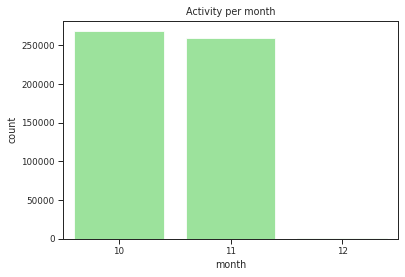

In [39]:
print(clients_activity_relevant.month.value_counts())
plt.figure(figsize = (6,4))
g = sns.countplot(x='month', data=clients_activity_relevant, color='lightgreen').set(title='Activity per month')

<font color='MediumBlue'>
Como se anticipó en la exploración del set de datos, solo existen datos para dos meses. Para el mes 12 solo hay 4 registros del día 1. Los eventos parecen estar balanceados entre el mes 10 y el mes 11.

[Text(0.5, 1.0, 'Activity per day of the month')]

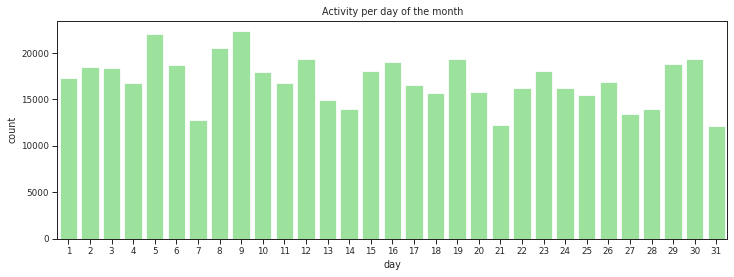

In [40]:
plt.figure(figsize = (12,4))
g = sns.countplot(x='day', data=clients_activity_relevant, color='lightgreen')
g.set(title='Activity per day of the month')

<font color='MediumBlue'>
No se aprecia un comportamiento claramente distinto según el día del mes del que se trate. Particularmente si puede verse un patrón de baja en la cantidad de registros cada 7 días. En el punto siguiente se analiza el compartamiento dentro de la semana.

Promedio registros los dias de semana: 86662
Promedio de registros durante el fin de semana: 47345


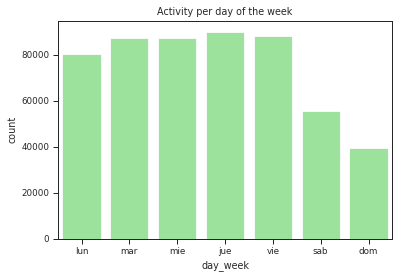

In [41]:
plt.figure(figsize = (6,4))
g = sns.countplot(x='day_week', data=clients_activity_relevant, color='lightgreen')
g.set(xticklabels = (['lun', 'mar', 'mie','jue','vie','sab','dom']))
g.set(title='Activity per day of the week')
act_semana=len(clients_activity_relevant[(clients_activity_relevant.day_week >= 0) & (clients_activity_relevant.day_week <= 4)])/5
act_fin_semana = len(clients_activity_relevant[(clients_activity_relevant.day_week >= 5) & (clients_activity_relevant.day_week <= 6)])/2
print('Promedio registros los dias de semana: {}\nPromedio de registros durante el fin de semana: {}'''.format(int(act_semana),int(act_fin_semana)))

<font color='MediumBlue'>
Dentro de la semana es evidente que el nivel de actividad de los usuarios es muy superior comparado con la actividad de los fines de semana. El promedio de registros de lunes a viernes es 83% superior al promedio de registros de sábado a domingo.

[Text(0.5, 1.0, 'Activity per hour of the day')]

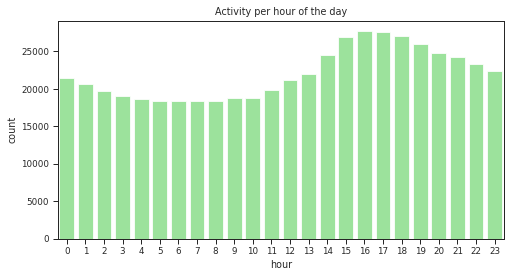

In [42]:
plt.figure(figsize = (8,4))
g = sns.countplot(x='hour', data=clients_activity_relevant, color='lightgreen')
g.set(title='Activity per hour of the day')

<font color='MediumBlue'>
Se puede apreciar que el nivel de actividad de los usuarios se incrementa entre las 14 y las 22 hs.

Mean:  248.66459278007375


Text(0.5, 0, 'Song lenght in seconds')

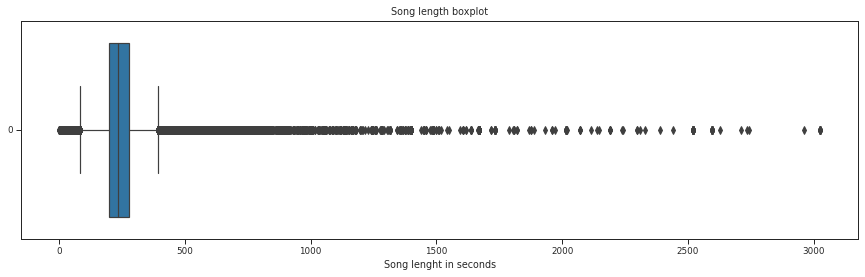

In [43]:
plt.figure(figsize = (15,4))
g=sns.boxplot(data=clients_activity_relevant.length,orient='h').set(title='Song length boxplot')
print('Mean: ', clients_activity_relevant.length.mean())
plt.xlabel('Song lenght in seconds')



<font color='MediumBlue'>
En cuanto a la duración de las canciones, se observa una distribución con gran cantidad de valores atípicos. Ya se había notado en incisos anteriores que el máximo era de 50 minutos. Sin embargo, el 50% de los registros tienen una duración de entre 3:19 (percentil 25) y 4:37 (percentil 75). <br><br>
<font color='MediumBlue'>
El valor mínimo de menos de un segundo de duración podría dar a entender que no se trata de la duración real de la canción sino del tiempo que el usuario lo reproduce. 
Se verifica que canción es: 




<font color='MediumBlue'>


In [44]:
clients_activity_relevant[clients_activity_relevant.length<1].song

158894    La Danza De Las Sombras
Name: song, dtype: object

### c. Una vez definido “Churn”, ¿las clases están balanceadas? (¿Hay más usuarios que hacen churn que los que no o viceversa?).

Text(0.5, 0.98, 'User count by churn criteria')

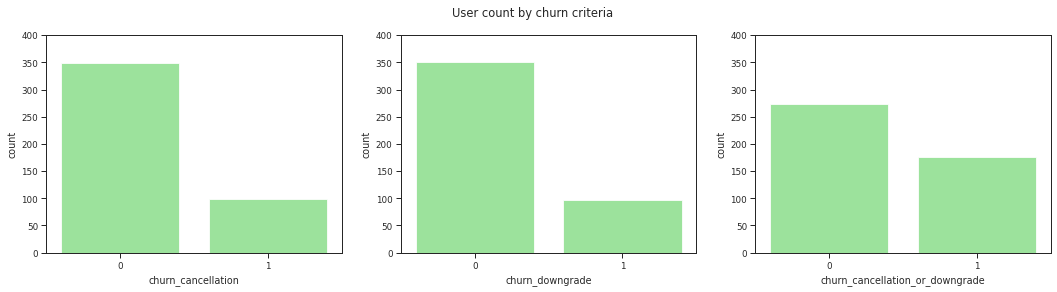

In [45]:
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
df_cc=clients_activity_relevant[['userId', 'churn_cancellation']].drop_duplicates(subset =['userId', 'churn_cancellation'], keep = 'first')
df_dg=clients_activity_relevant[['userId', 'churn_downgrade']].drop_duplicates(subset =['userId', 'churn_downgrade'], keep = 'first')
df_ccdg= clients_activity_relevant[['userId', 'churn_cancellation_or_downgrade']].drop_duplicates(subset =['userId', 'churn_cancellation_or_downgrade'], keep = 'first')
ax[0].set_ylim(bottom=0, top=400)
sns.countplot(x='churn_cancellation', data=df_cc, color='lightgreen',ax=ax[0])
ax[1].set_ylim(bottom=0, top=400)
sns.countplot(x='churn_downgrade', data=df_dg, color='lightgreen',ax=ax[1])
ax[2].set_ylim(bottom=0, top=400)
sns.countplot(x='churn_cancellation_or_downgrade', data=df_ccdg, color='lightgreen',ax=ax[2])
plt.suptitle('User count by churn criteria')

<font color='MediumBlue'>
Como se puede ver, son menos los usuarios que "hacen churn" respecto de los otros. Esto se cumple para cualquiera de los criterios que se adopten para definir el churn. Pero sí se observa que está mas balanceado si se toma como churn la cancelación o baja en el nivel del servicio.

### d. Comparar el comportamiento de los “usuarios churn” vs “usuarios no churn” en términos de:

<font color='MediumBlue'>
Para continuar con el análisis se decide definir que un usuario se considera que hizo churn cuand canceló el servicio, es decir, cuando la columna "churn_cancellation" es 1.

#### i. Uso a diferentes horas del día

[Text(0.5, 1.0, 'Activity per hour of the day')]

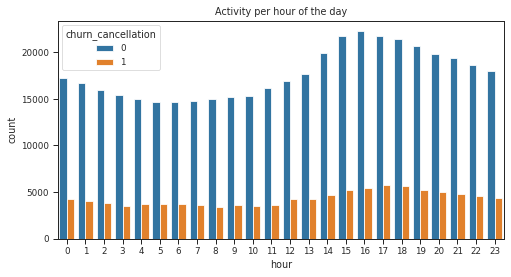

In [46]:
plt.figure(figsize = (8,4))
g = sns.countplot(x='hour', data=clients_activity_relevant, hue='churn_cancellation')
g.set(title='Activity per hour of the day')

<font color='MediumBlue'>
Como se puede ver, el patrón de uso durante el día es similar entre ambos grupos de usuarios.

#### ii. Uso en diferentes días de la semana

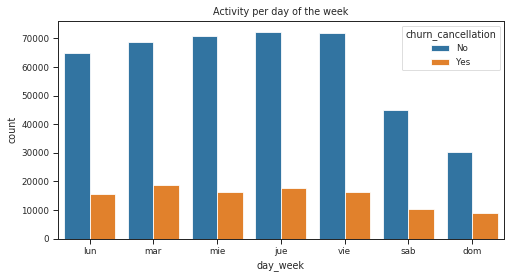

In [47]:
plt.figure(figsize = (8,4))
g = sns.countplot(x='day_week', data=clients_activity_relevant, hue='churn_cancellation')
g.set(xticklabels = (['lun', 'mar', 'mie','jue','vie','sab','dom']))
g.set(title='Activity per day of the week')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])

<font color='MediumBlue'>
Respecto al perfil de uso durante la semana, tampoco existe diferencia appreciable entre las dos clases de usuarios.

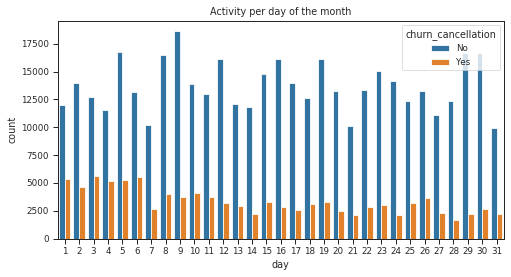

In [48]:
plt.figure(figsize = (8,4))
g = sns.countplot(x='day', data=clients_activity_relevant, hue='churn_cancellation')
g.set(title='Activity per day of the month')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])

<font color='MediumBlue'>
Existe una leve diferencia si se analiza el nivel de actividad de los usuarios según el día del mes. Dentro de la clase de usuarios churn, puede apreciarse que generan más actividad diaria los primeros 6 días respecto a la actividad diaria del resto del mes. Este comportamiento no es evidente para los usuarios que no han hecho churn.

#### iii. Nivel de usuario (gratuito o pago)

Proporción de usuarios del nivel gratuito que realizaron churn: 0.2847
Proporción de usuarios del nivel pago que realizaron churn: 0.3049


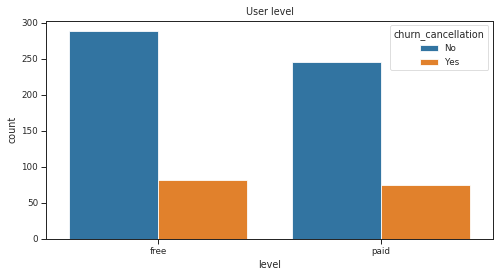

In [49]:
plt.figure(figsize = (8,4))
df_level=clients_activity_relevant[['userId', 'level','churn_cancellation']].drop_duplicates(subset =['userId', 'level'], keep = 'first')
g = sns.countplot(x='level', data=df_level, hue='churn_cancellation')
g.set(title='User level')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])
prop_free = round(len(df_level[(df_level.level=='free') & (df_level.churn_cancellation==1)])\
            /len(df_level[(df_level.level=='free') & (df_level.churn_cancellation==0)]),4)
prop_paid = round(len(df_level[(df_level.level=='paid') & (df_level.churn_cancellation==1)])\
            /len(df_level[(df_level.level=='paid') & (df_level.churn_cancellation==0)]),4)
print('Proporción de usuarios del nivel gratuito que realizaron churn: {}\nProporción de usuarios del nivel pago que realizaron churn: {}'\
        .format(prop_free,prop_paid))

<font color='MediumBlue'>
Si bien la proporción de usuario del nivel pago que realizan churn es superior a la proporción de aquellos del nivel gratuito (0.30 vs 0.28), no parece ser una diferencia significativa.

#### iv. Tipos de eventos (por ejemplo, añadir un amigo, publicidad, pulgares arriba)

<font color='MediumBlue'>
Se identifican los siguientes tipos de eventos:<br><br>
<strong>Experiencia positiva:</strong> Eventos que podrían ser indicadores de una experiencia positiva del usuario con la aplicación.<br>
- Add to Playlist<br>
- Add Friend<br>
- Thumbs Up/Down<br>
- Upgrade<br>
- Submit Upgrade<br>
<br>
<strong>Experiencia negativa:</strong> Eventos que podrían ser indicadores de una experiencia negativa del usuario con la aplicación.<br>
- Error<br>
- Help<br>
- Downgrade<br>
- Submit Downgrade<br>
- Cancel<br>
- Cancellation Confirmation<br>
<br>
<strong>Experiencia neutral:</strong> Eventos que no están asociados necesariamente a una experiencia negativa ni positiva.<br>
- Home<br>
- Logout<br>
- NextSong<br>
- About<br>
- Settings<br>
- Save Settings<br>
- Roll Advert<br>
<br>
A continuación se analiza el volumen de cada tipo de evento por grupo de usuarios (churn vs no churn).


In [50]:
positive = ['Add to Playlist', 'Add Friend', 'Thumbs Up', 'Thumbs Down', 'Upgrade', 'Submit Upgrade']
negative = ['Error', 'Help', 'Downgrade', 'Submit Downgrade', 'Cancel', 'Cancellation Confirmation']
neutral =  ['Home', 'Logout', 'NextSong', 'About', 'Settings', 'Save Settings', 'Roll Advert']
clients_activity_relevant_positive = clients_activity_relevant[clients_activity_relevant.page.isin(positive)]
clients_activity_relevant_negative = clients_activity_relevant[clients_activity_relevant.page.isin(negative)]
clients_activity_relevant_neutral = clients_activity_relevant[clients_activity_relevant.page.isin(neutral)]

In [51]:
#Se crea una nueva columna con los tipos de evento recategorizados
conditions = [clients_activity_relevant.page.isin(positive), \
              clients_activity_relevant.page.isin(negative), \
              clients_activity_relevant.page.isin(neutral)]
values = ['positive', 'negative', 'neutral']
clients_activity_relevant['event_type'] = np.select(conditions, values)
clients_activity_relevant.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,date,hour,day_week,day,month,year,churn_cancellation,churn_downgrade,churn_cancellation_or_downgrade,event_type
0,1538352011,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,2018-10-01 00:00:11,0,0,1,10,2018,1,1,1,neutral
1,1538352025,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,2018-10-01 00:00:25,0,0,1,10,2018,0,0,0,neutral
2,1538352118,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,2018-10-01 00:01:58,0,0,1,10,2018,0,0,0,neutral


Text(0.5, 0.98, 'Event types relative to group size')

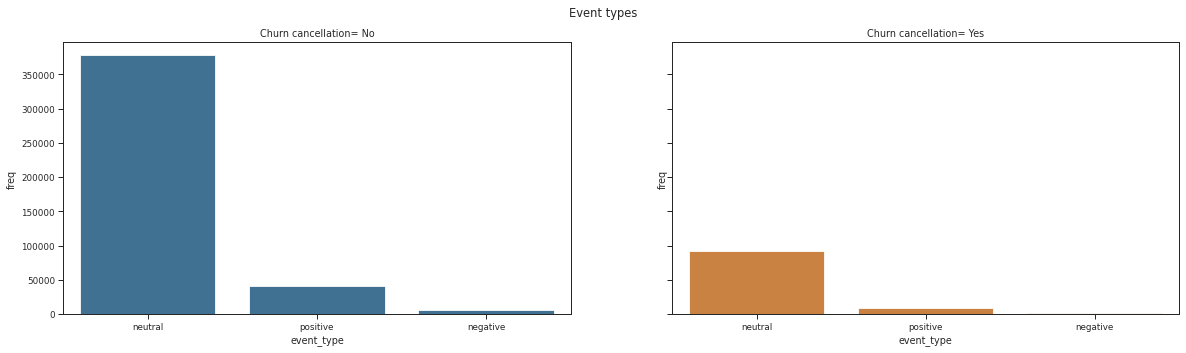

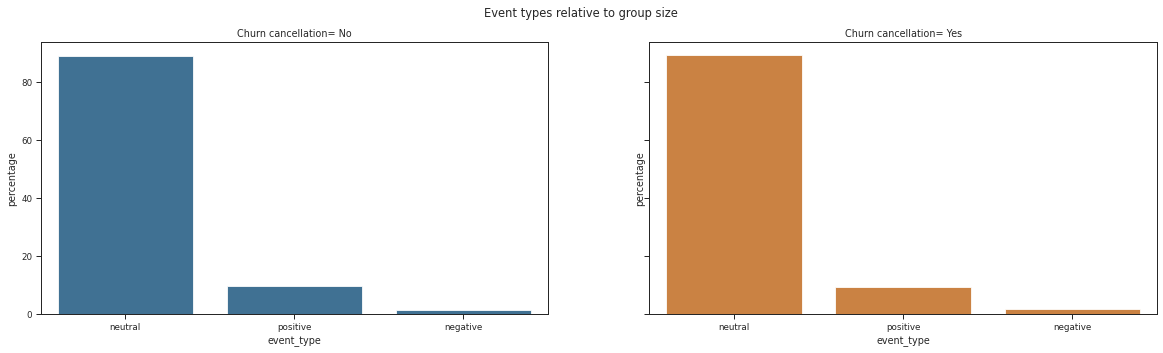

In [52]:
event_type_activity = clients_activity_relevant.groupby(by=['churn_cancellation','event_type'],sort=False)['userId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'userId': 'freq'})

fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.barplot(x='event_type', y='freq',data=event_type_activity[(event_type_activity.churn_cancellation==0)],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('event_type')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0, horizontalalignment='center')
ax[0].set_title('Churn cancellation= No')

sns.barplot(x='event_type', y='freq',data=event_type_activity[(event_type_activity.churn_cancellation==1)],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('event_type')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, horizontalalignment='center')

fig.suptitle('Event types')


et_churn = event_type_activity[event_type_activity.churn_cancellation==1]['freq'].sum()
et_no_churn = event_type_activity[event_type_activity.churn_cancellation==0]['freq'].sum()

event_type_activity['percentage'] = event_type_activity.apply(lambda row: (row['freq']/et_churn)*100\
                                                              if row['churn_cancellation']==1 else \
                                                              (row['freq']/et_no_churn)*100, axis=1)

fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.barplot(x='event_type', y='percentage',data=event_type_activity[(event_type_activity.churn_cancellation==0)],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('event_type')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0, horizontalalignment='center')
ax[0].set_title('Churn cancellation= No')

sns.barplot(x='event_type', y='percentage',data=event_type_activity[(event_type_activity.churn_cancellation==1)],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('event_type')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, horizontalalignment='center')
fig.suptitle('Event types relative to group size')

<font color='MediumBlue'>
No se observan diferencias significativas entre una clase de usuarios y la otra, la proporción de cada uno de los tipos de eventos es similar entre ambos grupos.

#### v. Dispositivo utilizado (por ejemplo, Mac, Windows, iPhone)

In [53]:
clients_activity_relevant['Operating_System']= clients_activity_relevant['userAgent'].apply(lambda x: "Windows" if "Windows" in x else ("Macintosh" if "Macintosh" in x else ("iPad" if "iPad" in x else ("iPhone" if "iPhone" in x else ("compatible" if "compatible" in x else("X11" if "X11" in x else None))))))
clients_activity_relevant.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,hour,day_week,day,month,year,churn_cancellation,churn_downgrade,churn_cancellation_or_downgrade,event_type,Operating_System
0,1538352011,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,0,0,1,10,2018,1,1,1,neutral,Macintosh
1,1538352025,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,0,0,1,10,2018,0,0,0,neutral,Macintosh
2,1538352118,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,0,0,1,10,2018,0,0,0,neutral,Macintosh
3,1538352119,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,0,0,1,10,2018,0,0,0,neutral,Macintosh
4,1538352124,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,0,0,1,10,2018,1,1,1,neutral,Windows


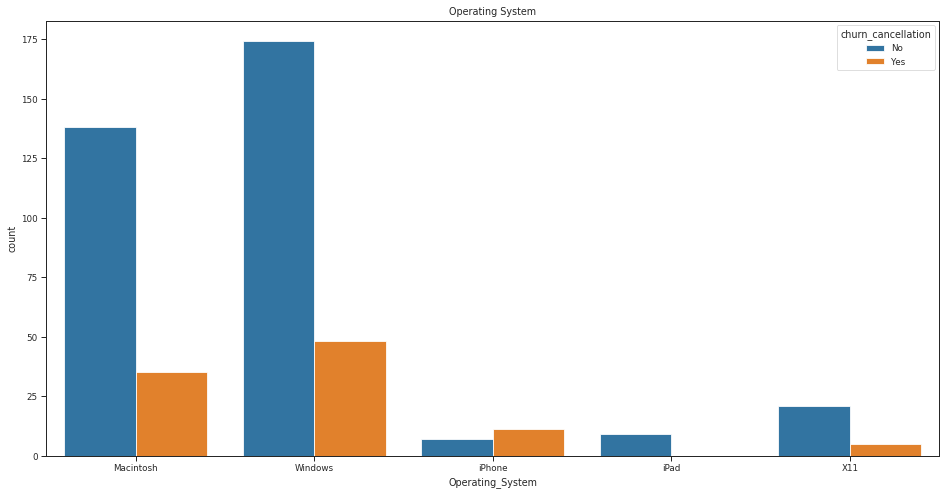

In [54]:
plt.figure(figsize = (16,8))
df_sistOper=clients_activity_relevant[['userId', 'Operating_System','churn_cancellation']].drop_duplicates(subset =['userId', 'Operating_System', 'churn_cancellation'], keep = 'first')
g = sns.countplot(x='Operating_System', data=df_sistOper, hue='churn_cancellation')
g.set(title='Operating System')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])

<font color='MediumBlue'>
Se observa que en general Windows es el sitema operativo más utilizado por los usuarios. Adicionalmente, entre quienes usan iPhone, es mayor la cantidad de usuarios que hacen churn que los que no hacen (a diferencia del resto de los sistemas operativos). Podría ser que la aplicación de streaming tenga problemas con dicho sistema operativo.

#### vi. Ubicación del usuario (por ejemplo, Nueva Inglaterra, Pacífico)

In [55]:
#Se hace una copia del DF dado que se agregan columnas nuevas
clients_activity_relevant_Backup=clients_activity_relevant.copy(deep=False)


In [56]:
#Se separa la columna location en 2 campos, location2 y Estados 
clients_activity_relevant[['location2','States']]=clients_activity_relevant.location.str.split(pat=', ', expand=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [57]:
#Se separa la columna location en 2 campos, location2 y Estados y luego se separa Estados en Estado para obtener un unico estado
clients_activity_relevant[['State0','State1', 'State2', 'State3']]=clients_activity_relevant.States.str.split(pat='-', expand=True)
#clients_activity_relevant.State0.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [58]:
# Se levanta archivo csv de codigos de region según código postal de EEUU
drive = connect_to_drive()
codpos = read_csv_from_drive(drive, '1tAQURZivnrxpyKVCAeImkur_cnGGLchW' , 'codpos.csv')
#Se visualiza una muestra de los datos
codpos.sample(5)

,CP,States,Region
1,NH,New Hampshire,Nueva Inglaterra
10,DE,Delaware,Atlantico Sur
23,TN,Tennessee,Centro Sur Oriental
6,NY,New York,Atlantico Medio
16,FL,Florida,Atlantico Sur


In [59]:
#Se unen los dataframe
clients_activity_relevant = clients_activity_relevant.merge(right=
    codpos[['CP','Region']], how='left',
    left_on='State0', right_on='CP', validate='many_to_one')

In [60]:
# vemos por que hay nulos en region
df_RegionNulos=clients_activity_relevant[clients_activity_relevant['Region'].isnull()==True]
df_RegionNulos.location.unique()

array(['Washington-Arlington-Alexandria, DC-VA-MD-WV'], dtype=object)

DC no corresponde a ningun Codigo Postal, segun tabla de codigos postales de EEUU
Link: https://codigo-postal.co/eeuu/
Para estos casos donde el codigo postal es: VA , MD y WV corresponden a la region: Atlantico Sur
Acorde a lo indicado en : https://es.wikipedia.org/wiki/Regiones_de_Estados_Unidos Tambien se puede ver en el link: https://codigo-postal.co/eeuu/maryland/

In [61]:
#21072022 - se agrega codigo para eliminar nulos en la variable region
# Efectuamos imputacion
clients_activity_relevant_Bck = clients_activity_relevant.copy(deep=True)
clients_activity_relevant.Region = clients_activity_relevant.Region.fillna('Atlantico Sur')

In [62]:
#Chequeamos null para Region
clients_activity_relevant.Region.isna().sum()

0

In [63]:
#Se quitan las columnas auxiliares que se crearon durante estos pasos previos
clients_activity_relevant.drop(labels=['location2','States','State1', 'State2', 'State3', 'CP'],inplace=True,axis=1)
clients_activity_relevant=clients_activity_relevant.rename(columns={'State0': 'State'})
clients_activity_relevant.sample(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,day,month,year,churn_cancellation,churn_downgrade,churn_cancellation_or_downgrade,event_type,Operating_System,State,Region
26676,1538746087,66,885,NextSong,Logged In,PUT,200,paid,234,"Los Angeles-Long Beach-Anaheim, CA",...,5,10,2018,0,0,0,neutral,Windows,CA,Pacifico
129456,1540233837,101,2161,NextSong,Logged In,PUT,200,paid,126,"Denver-Aurora-Lakewood, CO",...,22,10,2018,0,0,0,neutral,Windows,CO,Montaña
45333,1539087163,198,598,NextSong,Logged In,PUT,200,paid,152,"Gallup, NM",...,9,10,2018,1,0,1,neutral,Windows,NM,Montaña
446654,1541866870,200028,545,NextSong,Logged In,PUT,200,paid,172,"Washington-Arlington-Alexandria, DC-VA-MD-WV",...,10,11,2018,1,1,1,neutral,Macintosh,DC,Atlantico Sur
250627,1541686888,143,3219,Thumbs Up,Logged In,PUT,307,paid,33,"Virginia Beach-Norfolk-Newport News, VA-NC",...,8,11,2018,0,0,0,positive,Macintosh,VA,Atlantico Sur


Text(0.5, 0.98, 'Region relative to group size')

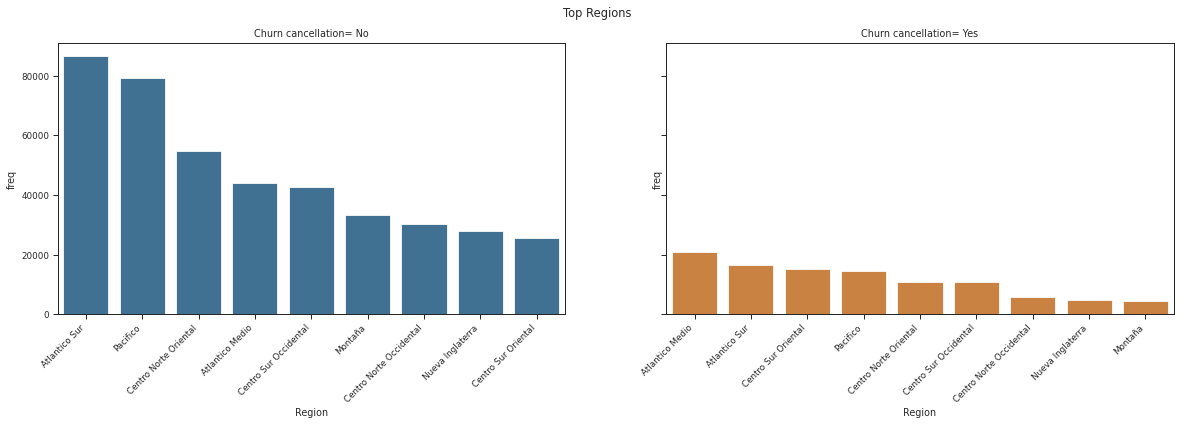

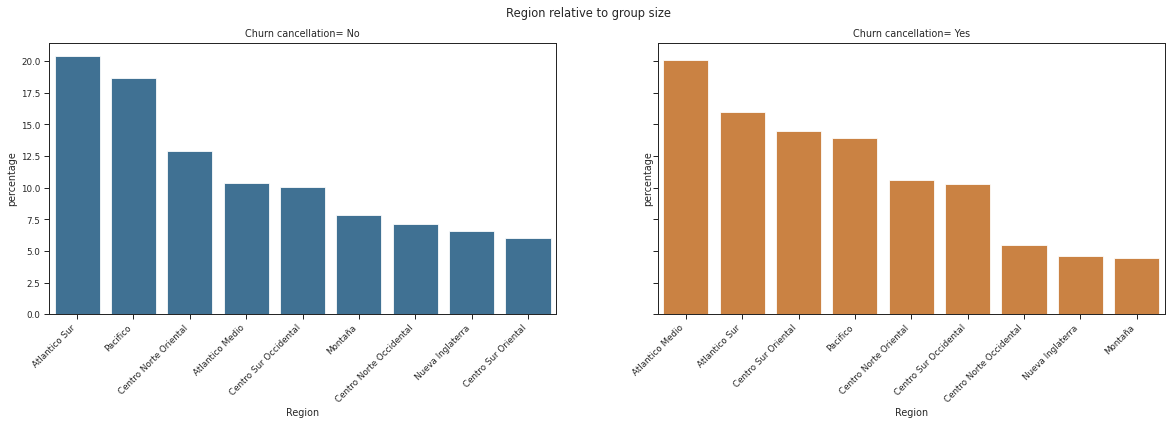

In [64]:
# Grafica de Ubicacion de Clientes por region 
regions = clients_activity_relevant.groupby(by=['churn_cancellation','Region'],sort=False)['userId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'userId': 'freq'})

#Subplot valores absolutos
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.barplot(x='Region', y='freq',data=regions[regions.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('Region')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='Region', y='freq',data=regions[regions.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('Region')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top Regions')
#Subplot valores relativos al tamaño del grupo
#add column percentage
churn = regions[regions.churn_cancellation==1]['freq'].sum()
no_churn = regions[regions.churn_cancellation==0]['freq'].sum()
regions['percentage'] = regions.apply(lambda row: (row['freq']/churn)*100 if row['churn_cancellation']==1 else (row['freq']/no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='Region', y='percentage',data=regions[regions.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('Region')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='Region', y='percentage',data=regions[regions.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('Region')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Region relative to group size')

<font color='MediumBlue'>
De la grafica de porcentajes se observa una importante concentracion de usuarios que hicieron Churn en las regiones: Atlantico Medio, Atlantico Sur, Centro Sur Oriental, Pacifico y Centro Norte Oriental, mientras que para la grafica de regiones que NO se hizo Churn se observa una distribucion mas uniforme.

#### vii. Tiempo transcurrido desde la baja (downgrade) hasta el abandono (Cancellation Confirmation).

<font color='MediumBlue'>
Se analizarán los eventos desde que los usuarios bajan de nivel su plan hasta que cancelan completamente el servicio. Por lo tanto, no se tendrán en cuenta para este análisis a los usuarios que NO HAN HECHO CHURN, sino solamente a los churned.<br>

<font color='MediumBlue'>
Se realiza un filtrado por usuario y evento del page que permite encontrar que existen usuarios que han realizado cancellation sin tener un upgrade previo en su plan, y esto se debe a que tomamos una porción de la base de datos total.  Por esto se han perdido datos de usuarios y sus eventos. 

<font color='MediumBlue'>
Para responder a esta consigna es necesario encontrar la fecha en la cuál CADA USUARIO CHURN hace su cancelación, y la fecha en la que realizó su suscription downgrade.<br>

<font color='MediumBlue'>
Se creará un nuevo dataframe que contenga SOLAMENTE a los usuarios que hicieron churn. Luego, se filtrarán los eventos del page para que queden solamente con aquellos eventos de submit downgrade y con cancellation confirmation.<br>

In [65]:
#se genera una copia del dataframe
downgrade_to_churn=clients_activity_relevant.copy() 

#se filtra para obtener solamente los usuarios que hicieron Churn
downgrade_to_churn=clients_activity_relevant[clients_activity_relevant['churn_cancellation'] == 1] 

#se filtra el "page" para que solo tenga submit_downgrade y cancellation_confirmation
cols_of_interest = ['Submit Downgrade', 'Cancellation Confirmation'] #lista con los eventos del page que nos interesan

#se hace uso de la función LOC para localizarlos y se guarda el dataframe filtrado en una nueva variable llamada "downgrade_to_churn_page_filter".
#Luego, se los reordena por fecha ascendente.
downgrade_to_churn_page_filter=downgrade_to_churn.loc[downgrade_to_churn['page'].isin(cols_of_interest)] 
downgrade_to_churn_page_filter['date'].sort_values(ascending=False)


388921   2018-11-30 13:05:07
388059   2018-11-30 09:27:17
385135   2018-11-29 20:13:18
384279   2018-11-29 17:49:03
377097   2018-11-28 21:36:34
                 ...        
394387   2018-10-02 14:50:59
6550     2018-10-02 12:19:53
393933   2018-10-01 23:45:44
2454     2018-10-01 13:30:16
1694     2018-10-01 08:24:07
Name: date, Length: 128, dtype: datetime64[ns]

<font color='MediumBlue'>
Aquí se obtuvo el dataframe con las filas filtradas y ordenadas desde la fecha más antigua a la más cercana al presente. Ahora se eliminarán los usuarios duplicados, que tengan más de un evento en page (por ejemplo usuarios con 3 eventos de submit downgrade).

In [66]:
#Se eliminan duplicados, para quedar solo con el primer evento de submit downgrade, ya que es el que usaremos como 
#referencia para calcular el tiempo desde que se dan de baja hasta que hacen cancellation confirmation.
downgrade_to_churn_page_filter.drop_duplicates(subset =['userId', 'page'], keep = 'first', inplace=True)
downgrade_to_churn_page_filter['page'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Cancellation Confirmation    99
Submit Downgrade             21
Name: page, dtype: int64

<font color='MediumBlue'>
downgrade_to_churn_page_filter contiene solamente las filas que cumplen las siguientes condiciones:<br>
- churn == 1<br>
- page filtrado por submit downgrade y cancellation confirmation<br>
- valores de userId y page events únicos (se eliminaron todos los duplicados, manteniendo el primer valor solamente), ordenados por fecha ascendente.<br>
<br>
Si se realiza un value_counts del 'page', se notará que hay usuarios que no tienen submit downgrade (existen 21 con submit downgrade, y 99 con cancellation confirmation), por lo tanto, no son de utilidad para este análisis. Se toman solamente aquellos que cumplan ambas condiciones: contar con submit downgrade y con cancellation confirmation. Para esto, se utilizarán las columnas que fueron creadas previamente: churn_downgrade y churn_cancellation.

In [67]:
#Para filtrar, se usa un "and (&)". Se almacena el resultado en una nueva variable llamada down_and_cancell.
down_and_cancel = downgrade_to_churn_page_filter[(downgrade_to_churn_page_filter['churn_cancellation']==1) & (downgrade_to_churn_page_filter['churn_downgrade']==1)]

#Se crea una lista y se analiza su longitud, para ver si coincide con la longitud esperada (42 datos de usuarios), ya que
#se debería tener 21 usuarios con submit downgrade y 21 con cancellation confirmation
lista_down_and_cancel=list(down_and_cancel['userId']) 
len(lista_down_and_cancel)

42

In [68]:
#Se reordenan los usuarios por userId y date
down_and_cancel.sort_values(['userId', 'date']) 

#Se reagrupan las filas usando como parámetro los usuarios.
down_and_cancel_agrupado=down_and_cancel.groupby(['userId'])

#Se genera una nueva columna que contendrá las fechas desde que se dan de baja hasta que hacen cancellation confirmation.
down_and_cancel['Down2Churn']=down_and_cancel_agrupado['date'].diff()

#Se deben eliminar los valores nulos que surgen de hacer la diferencia entre columnas.
final_data = down_and_cancel[down_and_cancel.Down2Churn.notna()]

#Recurrimos a la función .describe() para ver la información obtenida
final_data['Down2Churn'].describe()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count                            21
mean     24 days 18:15:54.571428571
std      15 days 08:16:44.672707656
min                 0 days 00:52:13
25%                14 days 09:23:46
50%                24 days 04:16:25
75%                36 days 17:00:40
max                47 days 05:30:06
Name: Down2Churn, dtype: object

<font color='MediumBlue'>
Se puede observar que, en promedio, un usuario demora alrededor de 24 días en darse de baja. Pese al resultado obtenido, se considera que el resultado hubiese sido mejor si se contase con una muestra de mayor tamaño, ya que 21 usuarios es una muestra pequeña.

#### viii. ¿Cuál es la distribución de los usuarios por género?

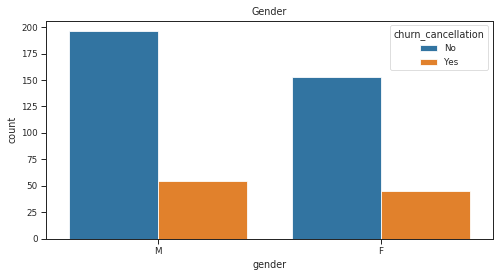

In [69]:
plt.figure(figsize = (8,4))
df_gender=clients_activity_relevant[['userId', 'gender','churn_cancellation']].drop_duplicates(subset =['userId', 'gender'], keep = 'first')
g = sns.countplot(x='gender', data=df_gender, hue='churn_cancellation')
g.set(title='Gender')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])

<font color='MediumBlue'>
En este punto tampoco se advierte un comporamiento diferente de los usuarios sujeto a su género.

#### ix. ¿Cuáles usuarios escucharon más canciones?

In [70]:
#Se analzian graficas para ambas clases

clients_activity_relevant_songs=clients_activity_relevant[clients_activity_relevant['page']=='NextSong']

top_songs = clients_activity_relevant_songs.groupby(by=['churn_cancellation','userId'],sort=False)['song'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'song': 'freq'})

Text(0.5, 0.98, 'Top 10 users - Amount of streamed songs')

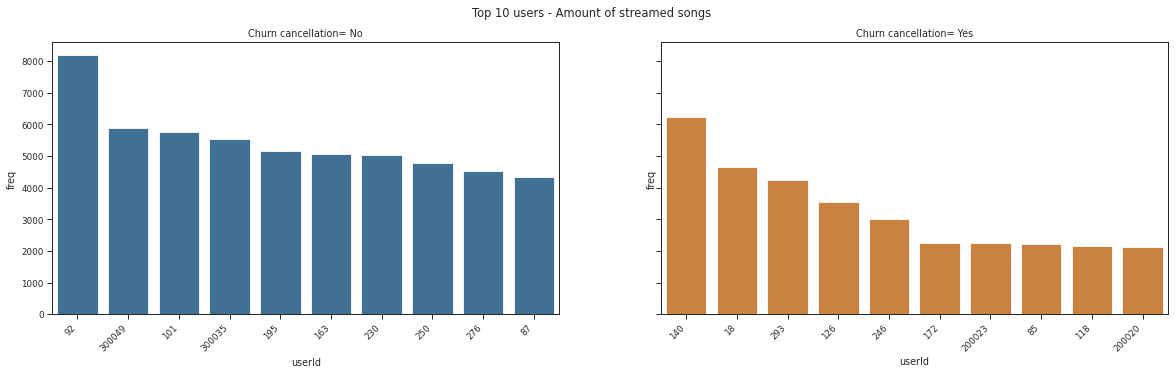

In [71]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
top_songs = clients_activity_relevant_songs.groupby(by=['churn_cancellation','userId'],sort=False)['song'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'song': 'freq'})
top_songs[top_songs.churn_cancellation==1][:10]
sns.barplot(x='userId', y='freq',data=top_songs[top_songs.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('userId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='userId', y='freq',data=top_songs[top_songs.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('userId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 users - Amount of streamed songs') 

<font color='MediumBlue'>
Entre los que no hicieron churn, el usuario que más canciones escuchó fue el número '92' con mas de 8 mil canciones escuchadas. Entre los que hicieron churn, el usuario que más canciones escuchó fue el '140', con más de 6 mil canciones escuchadas.

#### x. ¿Dónde se encuentra el mayor número de usuarios del servicio?

<font color='MediumBlue'>
Acorde a la grafica realizada en el punto vi , el mayor numero de usuarios se encuentra en el Atlantico Sur y Pacifico.

#### xi. ¿Cuántos artistas y canciones únicos tiene el conjunto de datos?


In [72]:
# se filtra por clase y se cuenta para artistas y para canciones

artists_churn= len(clients_activity_relevant[clients_activity_relevant.churn_cancellation==1].artist.unique())
artists_nochurn= len(clients_activity_relevant[clients_activity_relevant.churn_cancellation==0].artist.unique())

songs_churn=len(clients_activity_relevant[clients_activity_relevant.churn_cancellation==1].song.unique())
songs_nochurn=len(clients_activity_relevant[clients_activity_relevant.churn_cancellation==0].song.unique())

print('Artistas únicos para usuarios que hicieron churn:', artists_churn)
print('Artistas únicos para usuarios que no hicieron churn:', artists_nochurn)

print('Canciones únicas para usuarios que hicieron churn:', songs_churn)
print('Canciones únicas para usuarios que no hicieron churn:', songs_nochurn)

Artistas únicos para usuarios que hicieron churn: 12152
Artistas únicos para usuarios que no hicieron churn: 19993
Canciones únicas para usuarios que hicieron churn: 33144
Canciones únicas para usuarios que no hicieron churn: 72420


#### xii. ¿Cuáles son las canciones y artistas más populares?


Text(0.5, 0.98, 'Top 10 popular songs relative to group size')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


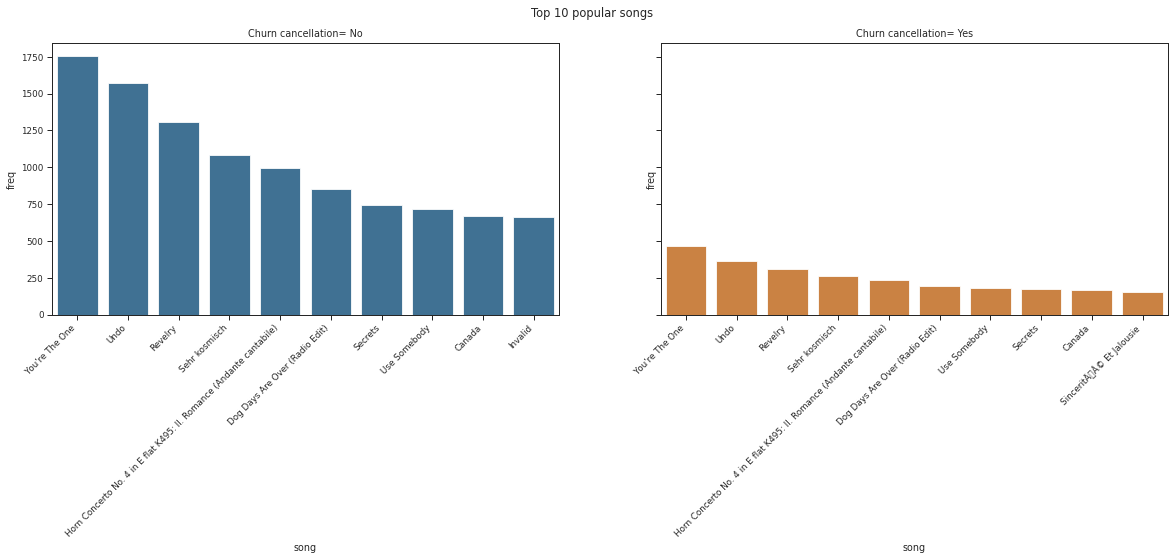

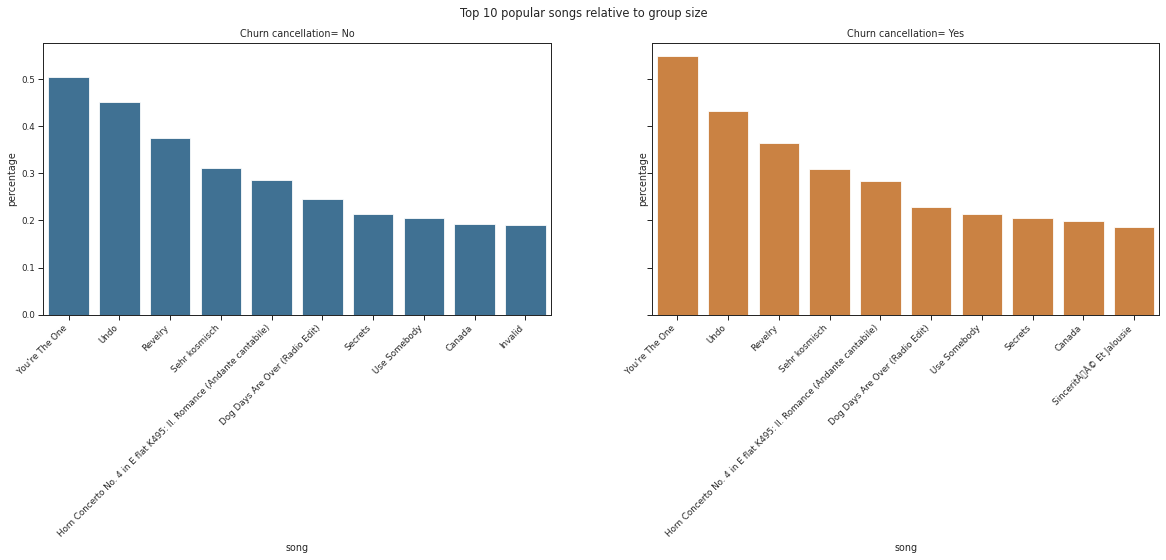

In [73]:
#Subplot valores absolutos
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
top_songs = clients_activity_relevant.groupby(by=['churn_cancellation','song'],sort=False)['userId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'userId': 'freq'})

sns.barplot(x='song', y='freq',data=top_songs[top_songs.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('song')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='song', y='freq',data=top_songs[top_songs.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('song')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 popular songs')
#Subplot valores relativos al tamaño del grupo
#add column percentage
churn = top_songs[top_songs.churn_cancellation==1]['freq'].sum()
no_churn = top_songs[top_songs.churn_cancellation==0]['freq'].sum()
top_songs['percentage'] = top_songs.apply(lambda row: (row['freq']/churn)*100 if row['churn_cancellation']==1 else (row['freq']/no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='song', y='percentage',data=top_songs[top_songs.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('song')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='song', y='percentage',data=top_songs[top_songs.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('song')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 popular songs relative to group size')

Text(0.5, 0.98, 'Top 10 popular artists relative to group size')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


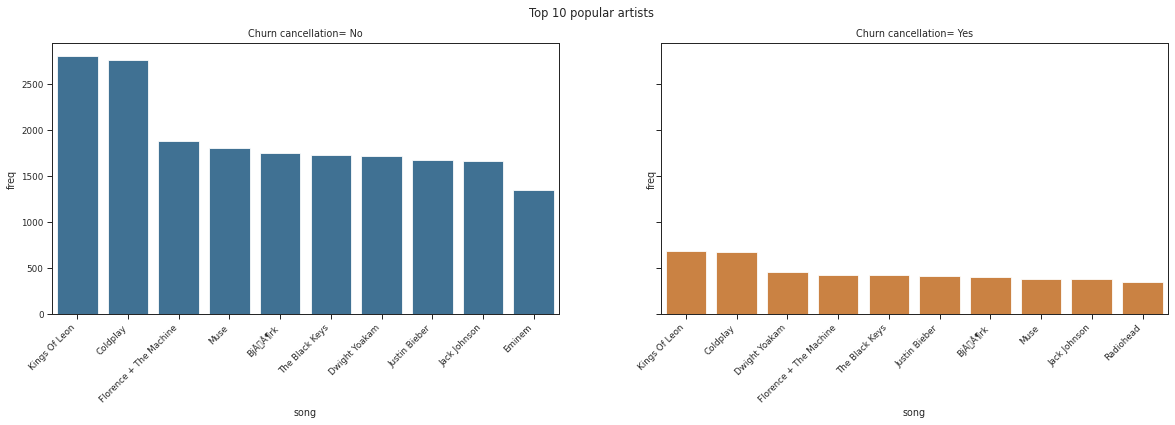

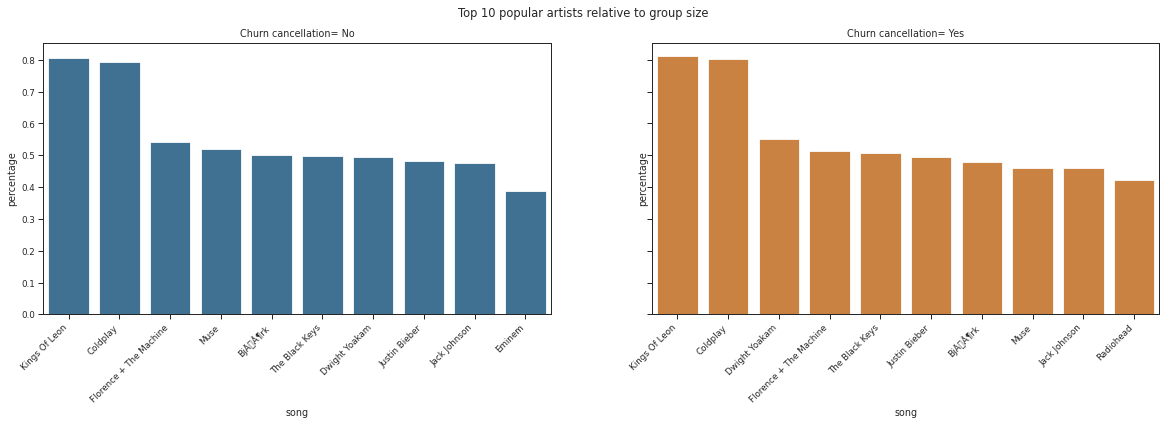

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
top_artists = clients_activity_relevant.groupby(by=['churn_cancellation','artist'],sort=True)['userId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'userId': 'freq'})
sns.barplot(x='artist', y='freq',data=top_artists[top_artists.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('song')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='artist', y='freq',data=top_artists[top_artists.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('song')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 popular artists')
#Subplot valores relativos al tamaño del grupo
#add column percentage
churn = top_artists[top_artists.churn_cancellation==1]['freq'].sum()
no_churn = top_artists[top_artists.churn_cancellation==0]['freq'].sum()
top_artists['percentage'] = top_artists.apply(lambda row: (row['freq']/churn)*100 if row['churn_cancellation']==1 else (row['freq']/no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='artist', y='percentage',data=top_artists[top_artists.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('song')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='artist', y='percentage',data=top_artists[top_artists.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('song')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 popular artists relative to group size')

<font color='MediumBlue'>
En general se puede ver que ambas clases de usuarios comparten preferencias similares en canciones y artistas.

#### xiii. ¿Qué usuarios han escuchado más canciones?

<font color='MediumBlue'>
En la consigna ix se observó que los usuarios que más canciones escucharon fueron el número '92' entre los que no hicieron churn y el número '140' entre los que hicieron churn.

#### xiv. Página más visitada

Text(0.5, 0.98, 'Top 10 visited pages relative to group size')

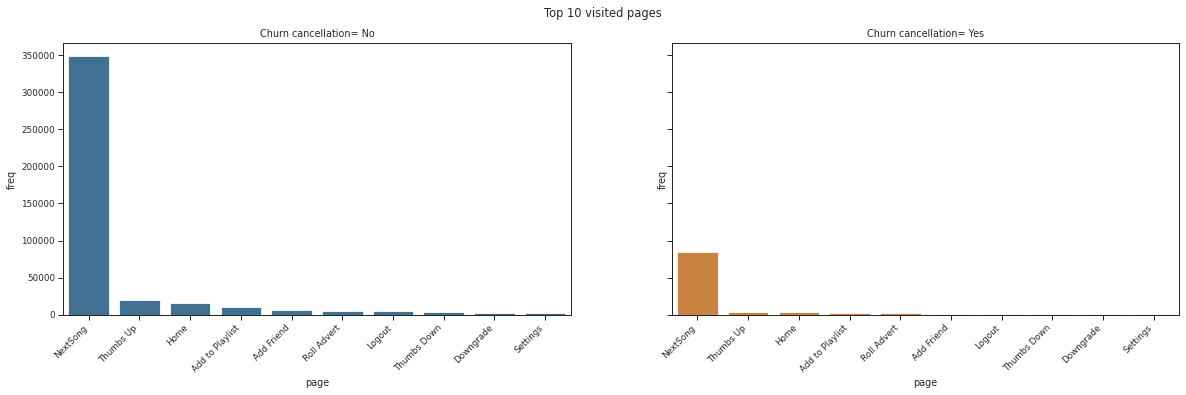

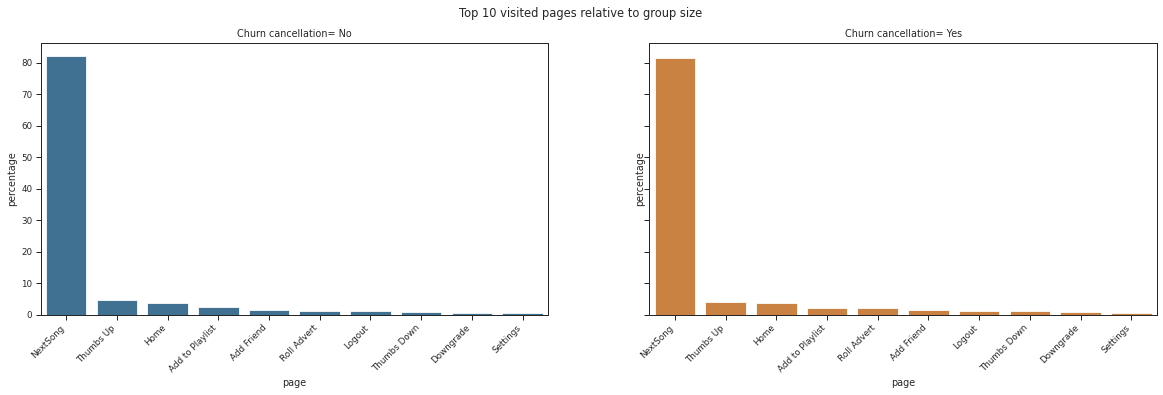

In [75]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
top_page = clients_activity_relevant.groupby(by=['churn_cancellation','page'],sort=False)['userId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'userId': 'freq'})
sns.barplot(x='page', y='freq',data=top_page[top_page.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('page')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='page', y='freq',data=top_page[top_page.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('page')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 visited pages')
#Subplot valores relativos al tamaño del grupo
#add column percentage
churn = top_page[top_page.churn_cancellation==1]['freq'].sum()
no_churn = top_page[top_page.churn_cancellation==0]['freq'].sum()
top_page['percentage'] = top_page.apply(lambda row: (row['freq']/churn)*100 if row['churn_cancellation']==1 else (row['freq']/no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='page', y='percentage',data=top_page[top_page.churn_cancellation==0][:10],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('page')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='page', y='percentage',data=top_page[top_page.churn_cancellation==1][:10],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('page')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 visited pages relative to group size')

Text(0.5, 0.98, 'Top 10 visited pages relative to group size')

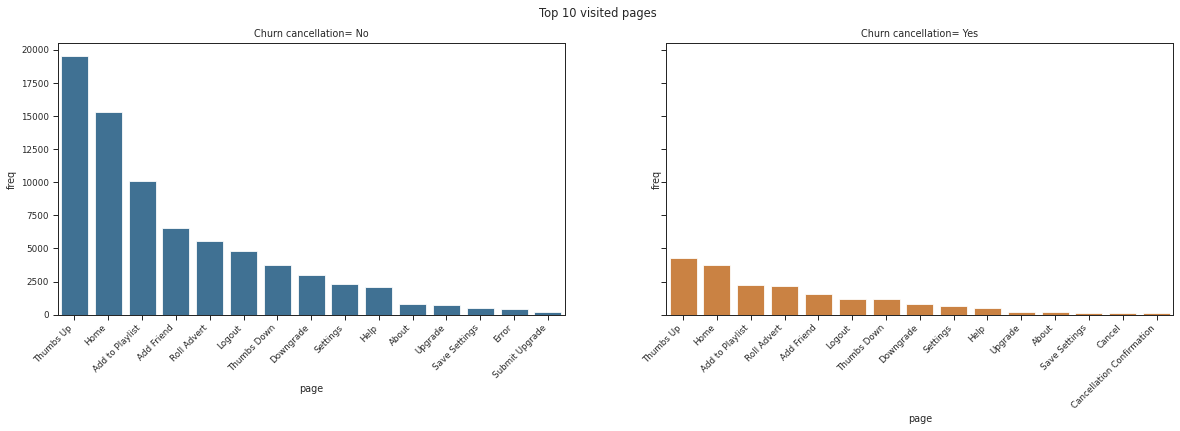

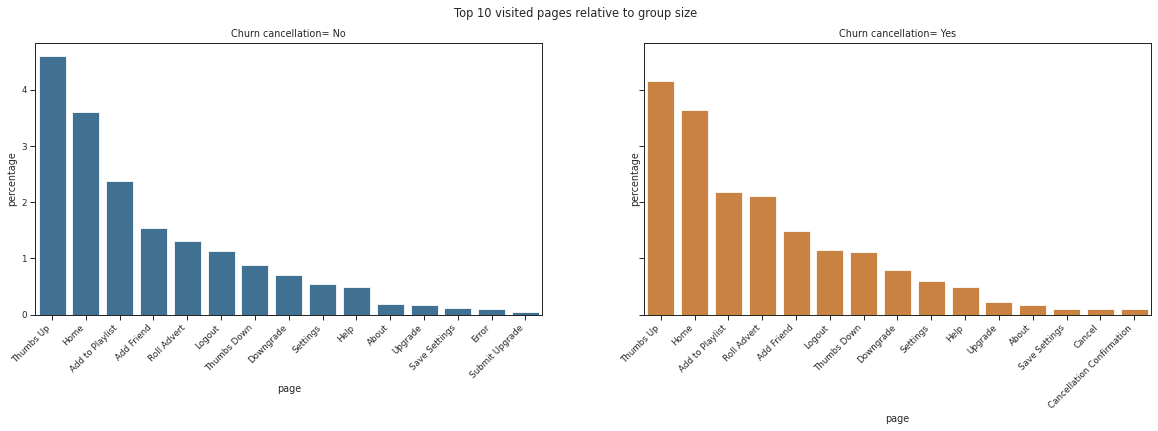

In [76]:
#Alternativa DESCARTANDO la columna "NextSong"
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
top_page = clients_activity_relevant.groupby(by=['churn_cancellation','page'],sort=True)['userId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'userId': 'freq'})
sns.barplot(x='page', y='freq',data=top_page[(top_page.churn_cancellation==0)&(top_page.page!='NextSong')][:15],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('page')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='page', y='freq',data=top_page[(top_page.churn_cancellation==1)&(top_page.page!='NextSong')][:15],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('page')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 visited pages')
#Subplot valores relativos al tamaño del grupo
#add column percentage
churn = top_page[top_page.churn_cancellation==1]['freq'].sum()
no_churn = top_page[top_page.churn_cancellation==0]['freq'].sum()
top_page['percentage'] = top_page.apply(lambda row: (row['freq']/churn)*100 if row['churn_cancellation']==1 else (row['freq']/no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='page', y='percentage',data=top_page[(top_page.churn_cancellation==0)&(top_page.page!='NextSong')][:15],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('page')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='page', y='percentage',data=top_page[(top_page.churn_cancellation==1)&(top_page.page!='NextSong')][:15],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('page')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Top 10 visited pages relative to group size')

<font color='MediumBlue'>
Se aprecia que los usuarios acceden a las mismas páginas, sean una clase de usuario o la otra.

#### xv. Analice las interacciones con la página “Help” por “userId” y por ‘sessionId’.

Text(0.5, 0.98, 'Interaction with page "Help" per userId relative to group size')

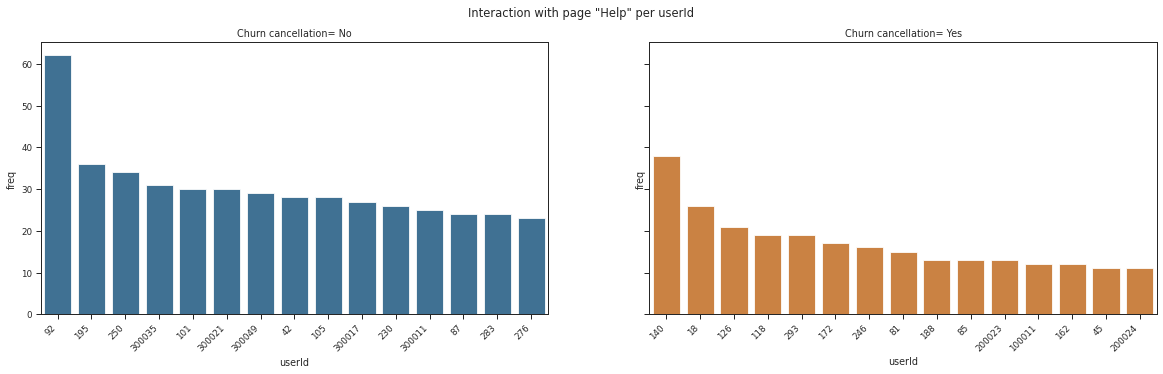

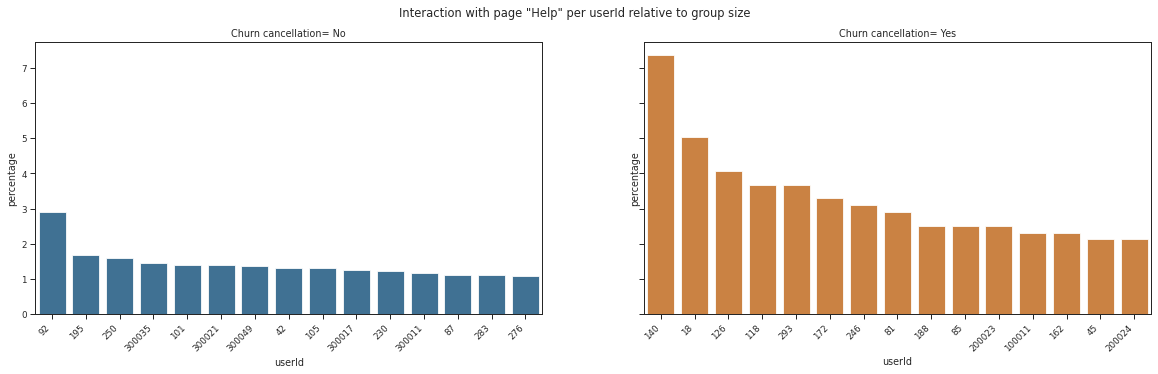

In [77]:
#Interacciones con la página "Help por userId"
clients_activity_relevant_help = clients_activity_relevant[clients_activity_relevant.page=='Help']
activity_help_page_userId = clients_activity_relevant_help.groupby(by=['churn_cancellation','userId'],sort=False)['sessionId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'sessionId': 'freq'})

fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='userId', y='freq',data=activity_help_page_userId[(activity_help_page_userId.churn_cancellation==0)][:15],color='#3274a1',ax=ax[0])

ax[0].set_xlabel('userId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='userId', y='freq',data=activity_help_page_userId[(activity_help_page_userId.churn_cancellation==1)][:15],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('userId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Interaction with page "Help" per userId')


#Subplot valores relativos al tamaño del grupo
#add column percentage
h_churn = activity_help_page_userId[activity_help_page_userId.churn_cancellation==1]['freq'].sum()
h_no_churn = activity_help_page_userId[activity_help_page_userId.churn_cancellation==0]['freq'].sum()

activity_help_page_userId['percentage'] = activity_help_page_userId.apply(lambda row: (row['freq']/h_churn)*100 if row['churn_cancellation']==1 else (row['freq']/h_no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.barplot(x='userId', y='percentage',data=activity_help_page_userId[(activity_help_page_userId.churn_cancellation==0)][:15],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('userId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')

sns.barplot(x='userId', y='percentage',data=activity_help_page_userId[(activity_help_page_userId.churn_cancellation==1)][:15],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('userId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Interaction with page "Help" per userId relative to group size')



Text(0.5, 0.98, 'Interaction with page "Help" per sessionId relative to group size')

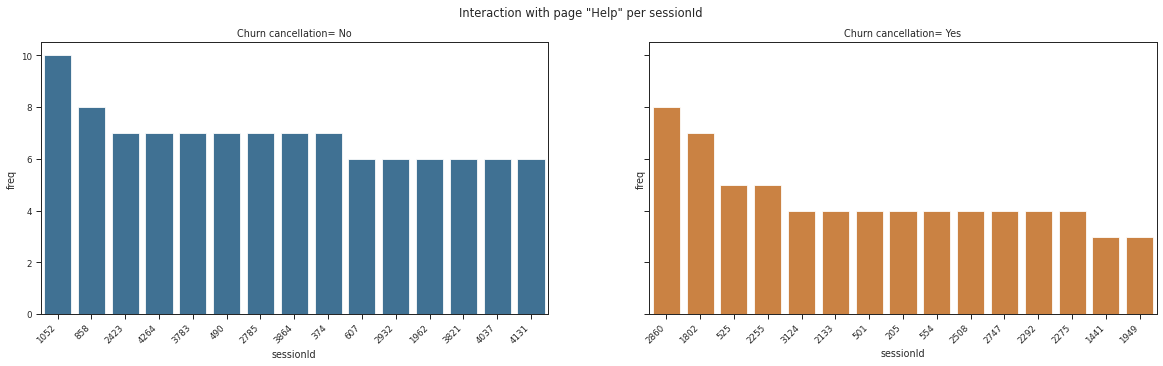

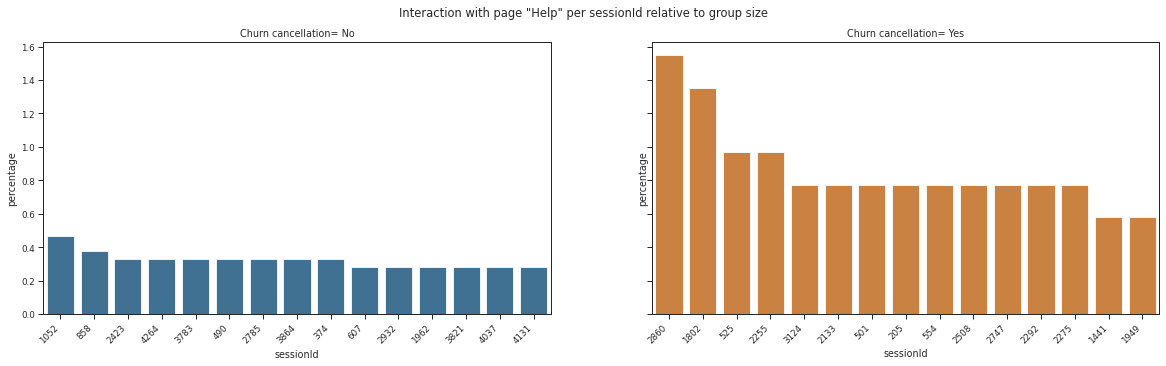

In [78]:
#Interacciones con la página "Help por sessionId"
activity_help_page_sessionId = clients_activity_relevant_help.groupby(by=['churn_cancellation','sessionId'],sort=False)['page'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'page': 'freq'})

data_nochurn = activity_help_page_sessionId[activity_help_page_sessionId.churn_cancellation==0][:15]
data_churn = activity_help_page_sessionId[activity_help_page_sessionId.churn_cancellation==1][:15]
order_nochurn = data_nochurn['sessionId']
order_churn = data_churn['sessionId']

fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='sessionId', y='freq',data=data_nochurn,color='#3274a1',ax=ax[0], order=order_nochurn)

ax[0].set_xlabel('sessionId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')

sns.barplot(x='sessionId', y='freq',data=data_churn,color='#e1812c',ax=ax[1], order=order_churn)
ax[1].set_xlabel('sessionId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Interaction with page "Help" per sessionId')

#Subplot valores relativos al tamaño del grupo
#add column percentage
ss_churn = activity_help_page_sessionId[activity_help_page_sessionId.churn_cancellation==1]['freq'].sum()
ss_no_churn = activity_help_page_sessionId[activity_help_page_sessionId.churn_cancellation==0]['freq'].sum()

activity_help_page_sessionId['percentage'] = activity_help_page_sessionId.apply(lambda row: (row['freq']/ss_churn)*100 if row['churn_cancellation']==1 else (row['freq']/ss_no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.barplot(x='sessionId', y='percentage',data=activity_help_page_sessionId[(activity_help_page_sessionId.churn_cancellation==0)][:15],color='#3274a1',ax=ax[0], order=order_nochurn)
ax[0].set_xlabel('sessionId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')

sns.barplot(x='sessionId', y='percentage',data=activity_help_page_sessionId[(activity_help_page_sessionId.churn_cancellation==1)][:15],color='#e1812c',ax=ax[1], order=order_churn)
ax[1].set_xlabel('sessionId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Interaction with page "Help" per sessionId relative to group size')

<font color='MediumBlue'>
Se observa que los usuarios que no hicieron churn interactuan más con la página de ayuda que aquellos que sí hacen churn. Sin embargo, se destaca que indistintamente de la página, el volumen de eventos de los usuarios que no hicieron churn es superior al de usuarios que sí hicieron churn.<br>
Este análisis es similar al comparar los sessionId.

#### xvi. ¿Cómo es la relación de ambos grupos (churn vs no churn) con la page == 'Error'?

Text(0.5, 0.98, 'Interaction with page "Error" per userId relative to group size')

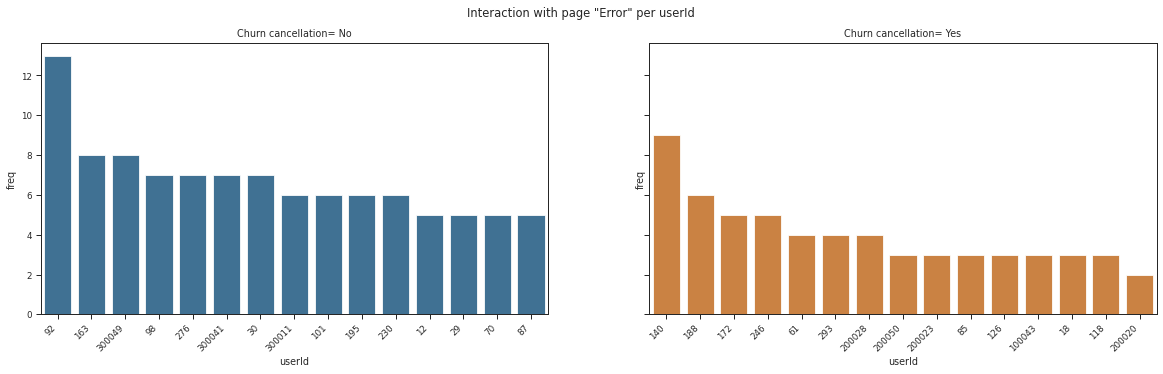

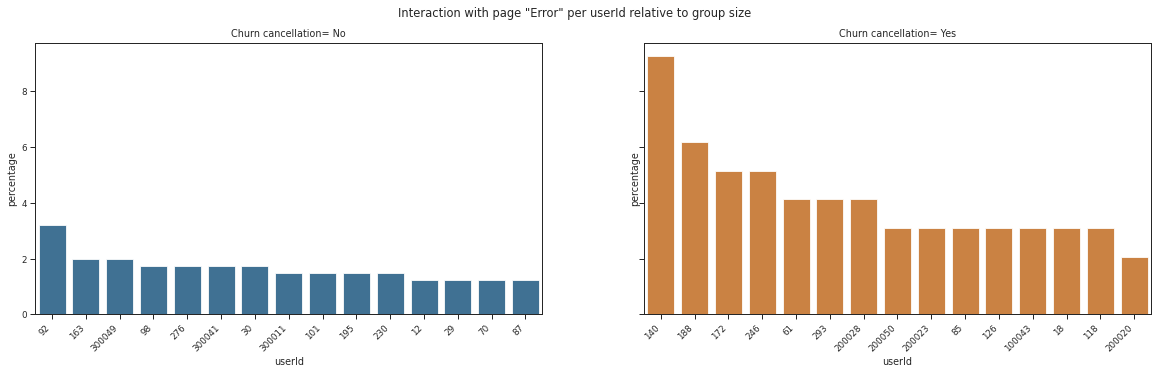

In [79]:
#Interacciones con la página "Error"
clients_activity_relevant_error = clients_activity_relevant[clients_activity_relevant.page=='Error']
activity_error_page = clients_activity_relevant_error.groupby(by=['churn_cancellation','userId'],sort=False)['sessionId'].count()\
            .sort_values(ascending=False).reset_index().rename(columns={'sessionId': 'freq'})

fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)
sns.barplot(x='userId', y='freq',data=activity_error_page[(activity_error_page.churn_cancellation==0)][:15],color='#3274a1',ax=ax[0])

ax[0].set_xlabel('userId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')
sns.barplot(x='userId', y='freq',data=activity_error_page[(activity_error_page.churn_cancellation==1)][:15],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('userId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Interaction with page "Error" per userId')

#Subplot valores relativos al tamaño del grupo
#add column percentage
e_churn = activity_error_page[activity_error_page.churn_cancellation==1]['freq'].sum()
e_no_churn = activity_error_page[activity_error_page.churn_cancellation==0]['freq'].sum()

activity_error_page['percentage'] = activity_error_page.apply(lambda row: (row['freq']/e_churn)*100 if row['churn_cancellation']==1 else (row['freq']/e_no_churn)*100, axis=1)
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.barplot(x='userId', y='percentage',data=activity_error_page[(activity_error_page.churn_cancellation==0)][:15],color='#3274a1',ax=ax[0])
ax[0].set_xlabel('userId')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_title('Churn cancellation= No')

sns.barplot(x='userId', y='percentage',data=activity_error_page[(activity_error_page.churn_cancellation==1)][:15],color='#e1812c',ax=ax[1])
ax[1].set_xlabel('userId')
ax[1].set_title('Churn cancellation= Yes')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.suptitle('Interaction with page "Error" per userId relative to group size')

<font color='MediumBlue'>
Nuevamente, se observa que los usuarios que no hicieron churn interactuan más con la página de error que aquellos que sí hacen churn.<br>

### e. En base a los puntos anteriores analice la correlación entre las variables y la variable target. 

<font color='MediumBlue'>
Según los puntos analizados anteriormente no se puede determinar que exista una clara correlación entre las variables analizadas y la variable target (churn_cancellation), que ayude a explicar el motivo por el que los usuarios hacen churn.<br>
Sería necesario avanzar con transformaciones sobre los datos para poder escalar el comportamiento de los usuarios en función al tiempo relativo que utilizaron el servicio.

### f. Analice el tiempo que pasa entre que un usuario se registra y es considerado “churn” (eventos 'Cancellation Confirmation' o 'Submit Downgrade'), calcule la media y mediana en cantidad de días.

In [80]:
clients_reg_churn=clients_activity_relevant #clients_reg_churn será nuestra nueva variable, sobre la que operaremos.

<font color='MediumBlue'>
Al igual que en el item "VII", se filtrarán aquellos usuarios que realizaron Churn, considerando que churn es cuando hacen cancellation confirmation. Para esto, se usará como referencia la columna "page", con el evento "Cancellation Confirmation".

In [81]:
cols_of_interest=['Cancellation Confirmation']
clients_reg_churn=clients_reg_churn.loc[clients_reg_churn['page'].isin(cols_of_interest)] 

In [82]:
#A continuación, se filtrarán los usuarios duplicados.
clients_reg_churn_no_dup=clients_reg_churn
clients_reg_churn_no_dup.drop_duplicates(subset =['userId', 'churn_cancellation'], keep = 'first', inplace=True)
clients_reg_churn_no_dup['userId'].nunique()

#Luego del filtrado por "Page" y por duplicados (teniendo en cuenta las columnas userId y churn_cancellation),
#nos quedamos con un total de 99 usuarios.

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


99

<font color='MediumBlue'>
Lo primero que se observa, es que la columna registration está en unidad timestamp, y que el orden de magnitud es incorrecto, ya que se está elevado a la 12va potencia, cuando realmente debería ser a la 9na potencia. Por esto, se divirirá a toda la columna por 1000.

In [83]:
clients_reg_churn_no_dup.registration

2454      1.536758e+12
6550      1.533473e+12
12226     1.529996e+12
15768     1.533888e+12
28348     1.535619e+12
              ...     
449485    1.537813e+12
450318    1.534625e+12
451609    1.535907e+12
484939    1.534513e+12
485228    1.534487e+12
Name: registration, Length: 99, dtype: float64

In [84]:
#Se creará una nueva columna con la registration date con un orden de magnitud correcto.
clients_reg_churn_no_dup['registration ok'] = clients_reg_churn_no_dup['registration']/1000
clients_reg_churn_no_dup[['userId', 'page', 'registration ok', 'churn_cancellation','date']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,userId,page,registration ok,churn_cancellation,date
2454,208,Cancellation Confirmation,1.536758e+09,1,2018-10-01 13:30:16
6550,231,Cancellation Confirmation,1.533473e+09,1,2018-10-02 12:19:53
12226,236,Cancellation Confirmation,1.529996e+09,1,2018-10-03 04:11:11
15768,156,Cancellation Confirmation,1.533888e+09,1,2018-10-03 18:48:49
28348,271,Cancellation Confirmation,1.535619e+09,1,2018-10-05 20:07:57
...,...,...,...,...,...
449485,200023,Cancellation Confirmation,1.537813e+09,1,2018-11-14 14:36:27
450318,200039,Cancellation Confirmation,1.534625e+09,1,2018-11-16 09:29:35
451609,200020,Cancellation Confirmation,1.535907e+09,1,2018-11-20 21:47:59
484939,300004,Cancellation Confirmation,1.534513e+09,1,2018-10-28 00:02:40




<font color='MediumBlue'>
Se creará un nuevo dataframe, que tendrá solamente 5 columnas de interés ('userId', 'page', 'registration ok', 'churn_cancellation', 'date'). Luego, se  convertirá la fecha de registro (que se encuentra en ts) a una unidad de tiempo más sencilla de interpretar por los humanos. Por último, se hará uso de la función lambda para restar los valores de dos columnas ('date' y 'registration date'), para obtener el tiempo que pasó desde que se registró hasta que hizo churn cancellation.<br>
Por último, se grafican en un histograma los resultados obtenidos, mostrando la media y mediana. Además, se almacenan la media y mediana en dos variables llamadas: mean_time_to_churn & median_time_to_churn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

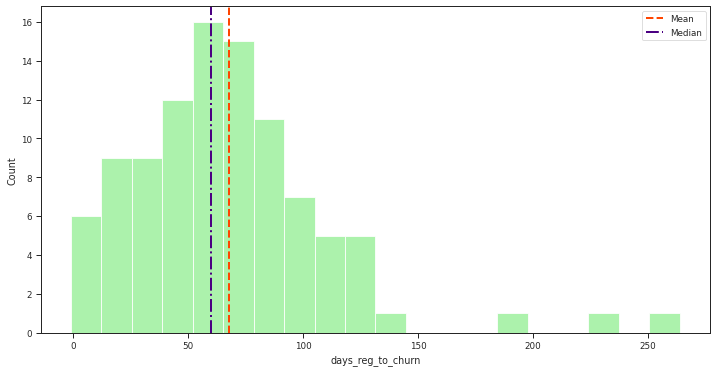

In [85]:
#Creación del nuevo dataframe que contendrá solamente las columnas que nos interesan.
date_convertion=clients_reg_churn_no_dup[['userId', 'page', 'registration ok', 'churn_cancellation','date']]


#Creación de nueva columna y almacenamiento del valor de la fecha en un formato más sencillo de interpretar por humanos.
date_convertion['registration ok']=pd.to_datetime(date_convertion['registration ok'], unit='s')


#Resta lugar a lugar de los valores de las columnas de interés
date_convertion['time_reg_to_churn'] = date_convertion.apply(lambda x: x['date'] - x['registration ok'], axis = 1)


#Conversión del formato de tiempo en día-hora-minuto-segundo a días (type: flotante)
date_convertion['days_reg_to_churn'] = date_convertion['time_reg_to_churn'].dt.total_seconds()/86400
date_convertion['days_reg_to_churn'] = date_convertion['days_reg_to_churn'].round(0).astype(int)

#Cálculo de la Media y Mediana
mean_time_to_churn=date_convertion['days_reg_to_churn'].mean()
median_time_to_churn=date_convertion['days_reg_to_churn'].median()


#Hisograma de los resultados obtenidos.
plt.figure(figsize=(12, 6))
sns.histplot(data=date_convertion['days_reg_to_churn'], bins=20, color='lightgreen')
plt.axvline(date_convertion['days_reg_to_churn'].mean(), linewidth=2, color='orangered',
            linestyle='--', label='Mean')
plt.axvline(date_convertion['days_reg_to_churn'].median(), linewidth=2, color='indigo',
            linestyle='-.', label='Median')
plt.legend()

In [86]:
print("Media de la cantidad de días entre que se registran y hacen churn:", mean_time_to_churn)
print("Mediana de la cantidad de días entre que se registran y hacen churn:", median_time_to_churn)

Media de la cantidad de días entre que se registran y hacen churn: 67.92929292929293
Mediana de la cantidad de días entre que se registran y hacen churn: 60.0


In [87]:
# Se incorpora la cantidad de días entre registro y churn para como nueva columna en el dataframe principal
# date_convertion_2 = date_convertion[['userId','days_reg_to_churn']]
clients_activity_relevant = clients_activity_relevant.merge(right=date_convertion[['userId','days_reg_to_churn']], how='left', on='userId', validate='many_to_one')

In [88]:
clients_activity_relevant.sample(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,month,year,churn_cancellation,churn_downgrade,churn_cancellation_or_downgrade,event_type,Operating_System,State,Region,days_reg_to_churn
419584,1538439476,200045,89,NextSong,Logged In,PUT,200,free,48,"Atlanta-Sandy Springs-Roswell, GA",...,10,2018,1,1,1,neutral,Windows,GA,Atlantico Sur,264.0
207504,1541180765,136,2984,NextSong,Logged In,PUT,200,free,48,"Charlotte-Concord-Gastonia, NC-SC",...,11,2018,0,0,0,neutral,Macintosh,NC,Atlantico Sur,NaN
389058,1543584585,173,4758,Logout,Logged In,PUT,307,free,28,"Austin-Round Rock, TX",...,11,2018,0,1,1,neutral,Macintosh,TX,Centro Sur Occidental,NaN
121753,1540104660,259,2080,NextSong,Logged In,PUT,200,paid,244,"New York-Newark-Jersey City, NY-NJ-PA",...,10,2018,0,1,1,neutral,Macintosh,NY,Atlantico Medio,NaN
302816,1542337576,33,3701,NextSong,Logged In,PUT,200,paid,264,"Hartford-West Hartford-East Hartford, CT",...,11,2018,0,0,0,neutral,Macintosh,CT,Nueva Inglaterra,NaN


### g. ¿Cuáles columnas resultan “interesantes” para ser incluídas en un futuro modelo predictivo de churn? (Debieran ser aquellas que presentan cierto comportamiento diferente para los usuarios churn o no churn).:

<font color='MediumBlue'>
De lo analizado anteriormente, gran parte de las variables revisadas no parecen mostrar diferencias marcadas entre los usuarios de cada clase. Para poder avanzar en seleccionar variables más interesantes para predecir el comportamiento de los usuarios, será necesario comenzar a trabajar con transformaciones de las variables e incorporando otras generadas a partir de los datos existentes. Por ejemplo: <br> <br>
*   Cantidad de días totales de interacción con la aplicación <br>
*   Tiempo transcurrido (días) entre la fecha mínima y la fecha máxima de interacciones por usuario <br>
*   Relación entre las anteriores dos columnas <br>
*   Cantidad de veces que el usuario hizo submit downgrade, entre otras.



##Exportar a cvs

In [89]:
clients_activity_relevant.to_csv("salida_TP1.csv", index=None) #poner acá el nombre del DF que se usa final
from google.colab import files
files.download('salida_TP1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>